<h1>Milestone 1</h1>

<h1>1.⁠ ⁠Understand distribution of contract sizes & lengths </h1>

In [ ]:
txt_folder = "../data/raw/full_contract_txt"

txt_files = os.listdir(txt_folder)
print("Total TXT files:", len(txt_files))

txt_files[:10]

Total TXT files: 510


['2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement.txt',
 'ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEMENT.txt',
 'ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-EX-10.13-JOINT VENTURE AGREEMENT.txt',
 'ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT.txt',
 'ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT.txt',
 'ADAPTIMMUNETHERAPEUTICSPLC_04_06_2017-EX-10.11-STRATEGIC ALLIANCE AGREEMENT.txt',
 'ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT.txt',
 'ADMA BioManufacturing, LLC -  Amendment #3 to Manufacturing Agreement .txt',
 'ADUROBIOTECH,INC_06_02_2020-EX-10.7-CONSULTING AGREEMENT(1).txt',
 'ADUROBIOTECH,INC_06_02_2020-EX-10.7-CONSULTING AGREEMENT.txt']

In [ ]:
texts = {}

for file in txt_files:
    path = os.path.join(txt_folder, file)

    try:
        with open(path, "r", encoding="utf-8") as f:
            texts[file] = f.read()
    except:
        with open(path, "r", encoding="latin-1") as f:
            texts[file] = f.read()

print("Loaded", len(texts), "files successfully.")

Loaded 510 files successfully.


In [ ]:
stats = []

for filename, text in texts.items():
    words = text.split()
    stats.append({
        "filename": filename,
        "word_count": len(words),
        "char_count": len(text),
        "empty": len(words) == 0
    })

df_stats = pd.DataFrame(stats)
df_stats.head()


,filename,word_count,char_count,empty
0,2ThemartComInc_19990826_10-12G_EX-10.10_670028...,4467,29454,False
1,ABILITYINC_06_15_2020-EX-4.25-SERVICES AGREEME...,4115,26346,False
2,ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-...,1911,13038,False
3,ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGR...,13349,89484,False
4,ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT A...,3770,24632,False


In [ ]:
import pandas as pd

# Step 1: Create stats dataframe
stats = []

for filename, text in texts.items():
    words = text.split()
    stats.append({
        "filename": filename,
        "word_count": len(words),
        "char_count": len(text),
        "empty": len(words) == 0
    })

df_stats = pd.DataFrame(stats)
df_stats.head()

# Step 2: Summary statistics
total_contracts = df_stats.shape[0]
avg_words_per_contract = df_stats["word_count"].mean()
median_words_per_contract = df_stats["word_count"].median()
smallest_contract = df_stats["word_count"].min()
largest_contract = df_stats["word_count"].max()

# Step 3: Print results
print(f"Total contracts: {total_contracts}")
print(f"Average words per contract: {avg_words_per_contract:.2f}")
print(f"Median words per contract: {median_words_per_contract}")
print(f"Smallest contract (word count): {smallest_contract}")
print(f"Largest contract (word count): {largest_contract}")

Total contracts: 510
Average words per contract: 7861.19
Median words per contract: 5006.0
Smallest contract (word count): 109
Largest contract (word count): 47733


In [ ]:
df_stats[df_stats["empty"] == True]

,filename,word_count,char_count,empty


In [ ]:
# Detect empty or very short contracts
empty_files_count = df_stats[df_stats["empty"] == True].shape[0]
short_files_count = df_stats[df_stats["word_count"] < 100].shape[0]
valid_contracts_count = df_stats[(df_stats["empty"] == False) & (df_stats["word_count"] >= 100)].shape[0]

# Print the results
print(f"Empty files count: {empty_files_count}")
print(f"Short files (< 100 words) count: {short_files_count}")
print(f"Valid contracts eligible for analyzing count: {valid_contracts_count}")

Empty files count: 0
Short files (< 100 words) count: 0
Valid contracts eligible for analyzing count: 510


In [ ]:

from collections import Counter
import pandas as pd

# Combine all texts
all_text = " ".join(texts.values())
words = all_text.lower().split()

# Words to remove
remove_list = ["the", "and", "of", "to", "in", "for", "on", "a"]

# Filter words: length > 4 and not in remove_list
legal_words = [w for w in words if len(w) > 4 and w not in remove_list]

# Count frequency
counter = Counter(legal_words)
common_words = counter.most_common(20)

# Convert to dataframe for table display
df_common_words = pd.DataFrame(common_words, columns=["Word", "Frequency"])

# Display header and table
print("Top 20 frequent words")
df_common_words

Top 20 frequent words


,Word,Frequency
0,shall,47817
1,agreement,26123
2,other,25361
3,party,24790
4,under,13963
5,section,12920
6,which,12479
7,parties,10135
8,[***],9101
9,company,8577


C:\Users\AMANS\AppData\Local\Temp\ipykernel_18184\2439949852.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(labels, rotation=75)


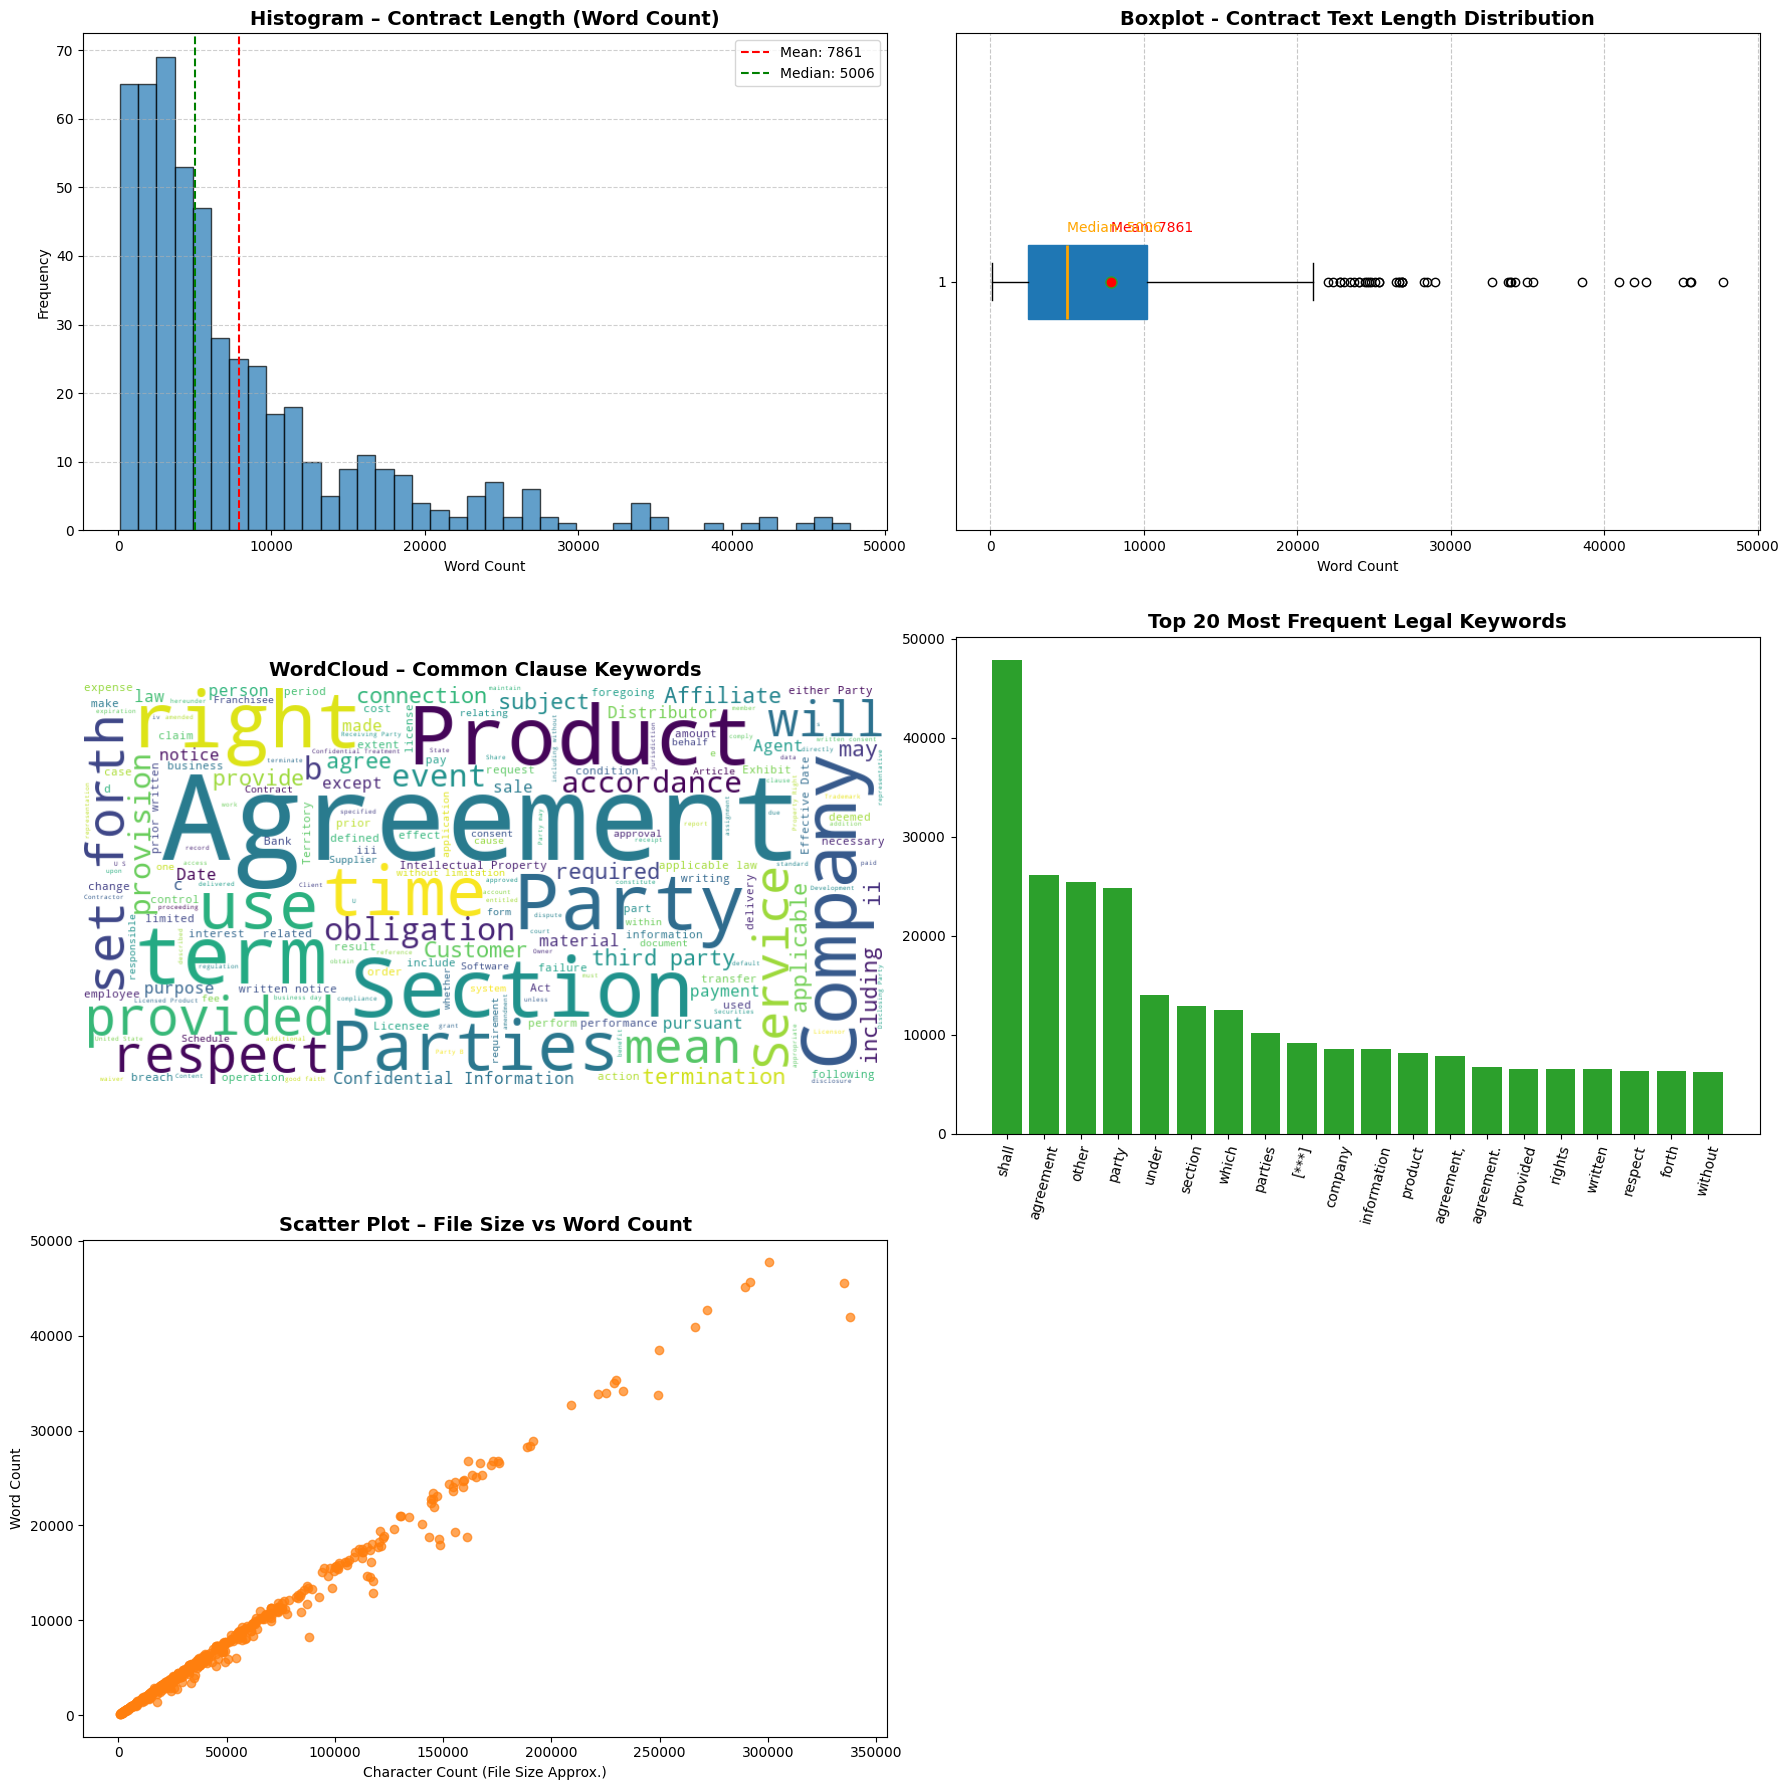

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from collections import Counter

# Prepare WordCloud data
all_text = " ".join(texts.values())
words = all_text.lower().split()
remove_list = ["the", "and", "of", "to", "in", "for", "on", "a"]
legal_words = [w for w in words if len(w) > 4 and w not in remove_list]
counter = Counter(legal_words)
common_words = counter.most_common(20)
labels, counts = zip(*common_words)
wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Prepare stats
mean_wc = df_stats["word_count"].mean()
median_wc = df_stats["word_count"].median()

#  subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# 1. Histogram
axes[0,0].hist(df_stats["word_count"], bins=40, color="#1f77b4", edgecolor="black", alpha=0.7)
axes[0,0].set_title("Histogram – Contract Length (Word Count)", fontsize=14, fontweight="bold")
axes[0,0].set_xlabel("Word Count")
axes[0,0].set_ylabel("Frequency")
axes[0,0].grid(axis="y", linestyle="--", alpha=0.6)
axes[0,0].axvline(mean_wc, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_wc:.0f}')
axes[0,0].axvline(median_wc, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_wc:.0f}')
axes[0,0].legend()

# 2. Boxplot
boxprops = dict(facecolor="#1f77b4", color="#1f77b4")
medianprops = dict(color="orange", linewidth=2)
meanprops = dict(marker="o", markerfacecolor="red", markersize=8)
axes[0,1].boxplot(df_stats["word_count"], vert=False, patch_artist=True,
                  boxprops=boxprops, medianprops=medianprops,
                  showmeans=True, meanprops=meanprops)
axes[0,1].set_title("Boxplot - Contract Text Length Distribution", fontsize=14, fontweight="bold")
axes[0,1].set_xlabel("Word Count")
axes[0,1].grid(axis="x", linestyle="--", alpha=0.7)
axes[0,1].text(mean_wc + 5, 1.1, f'Mean: {mean_wc:.0f}', color='red', fontsize=10)
axes[0,1].text(median_wc + 5, 1.1, f'Median: {median_wc:.0f}', color='orange', fontsize=10)

# 3. WordCloud
axes[1,0].imshow(wc, interpolation="bilinear")
axes[1,0].axis("off")
axes[1,0].set_title("WordCloud – Common Clause Keywords", fontsize=14, fontweight="bold")

# 4. Bar chart
axes[1,1].bar(labels, counts, color="#2ca02c")
axes[1,1].set_xticklabels(labels, rotation=75)
axes[1,1].set_title("Top 20 Most Frequent Legal Keywords", fontsize=14, fontweight="bold")

# 5. Scatter plot (spanning bottom row)
fig.delaxes(axes[2,1])  # Remove unused subplot
axes[2,0].scatter(df_stats["char_count"], df_stats["word_count"], color="#ff7f0e", alpha=0.7)
axes[2,0].set_xlabel("Character Count (File Size Approx.)")
axes[2,0].set_ylabel("Word Count")
axes[2,0].set_title("Scatter Plot – File Size vs Word Count", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

<h1> 🔹 TEXT CLEANING  </h1>

In [ ]:
import os
import re


def clean_text(text):
    # Remove page headers/footers
    text = re.sub(r"Page\s*\d+|\f", " ", text)

    # Remove non-ASCII characters
    text = re.sub(r"[^\x00-\x7F]+", " ", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)

    # Remove repeated line breaks
    text = re.sub(r'\n+', '\n', text)

    # Remove noisy characters (keep letters, numbers, punctuation)
    text = re.sub(r"[^a-zA-Z0-9.,;:()\-\/\n ]", "", text)

    # Fix broken hyphenation (e.g., "exam-\nple" -> "example")
    text = re.sub(r"-\s*\n\s*", "", text)

    # Strip extra spaces
    cleaned = text.strip()

    return cleaned

# -----------------------------
# Clean ALL files in input folder
# -----------------------------
input_folder = "../data/raw/full_contract_txt"
output_folder = "../data/transformed"
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        raw_path = os.path.join(input_folder, filename)

        # Read raw file
        with open(raw_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Clean text using combined function
        cleaned_text = clean_text(text)

        # Save cleaned file
        cleaned_filename = filename.replace(".txt", "_cleaned.txt")
        out_path = os.path.join(output_folder, cleaned_filename)
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(cleaned_text)

print("✔ All cleaned files saved to data/transformed/")


<h1>Sentence Splitting & Chunking with Overlap Chunk Strategy We split into: Batch size 12 gb ram ## FInal (Only chunks NO emneddings )</h1>

c:\Users\AMANS\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Paths ready
✓ Processed → contract_001_chunks.json
✓ Processed → contract_002_chunks.json
✓ Processed → contract_003_chunks.json
✓ Processed → contract_004_chunks.json
✓ Processed → contract_005_chunks.json
✓ Processed → contract_006_chunks.json
✓ Processed → contract_007_chunks.json
✓ Processed → contract_008_chunks.json
✓ Processed → contract_009_chunks.json
✓ Processed → contract_010_chunks.json
✓ Processed → contract_011_chunks.json
✓ Processed → contract_012_chunks.json
✓ Processed → contract_013_chunks.json
✓ Processed → contract_014_chunks.json
✓ Processed → contract_015_chunks.json
✓ Processed → contract_016_chunks.json
✓ Processed → contract_017_chunks.json
✓ Processed → contract_018_chunks.json
✓ Processed → contract_019_chunks.json
✓ Processed → contract_020_chunks.json
✓ Processed → contract_021_chunks.json
✓ Processed → contract_022_chunks.json
✓ Processed → contract_023_chunks.json
✓ Processed → contract_024_chunks.json
✓ Processed → contract_025_chunks.json
✓ Processed

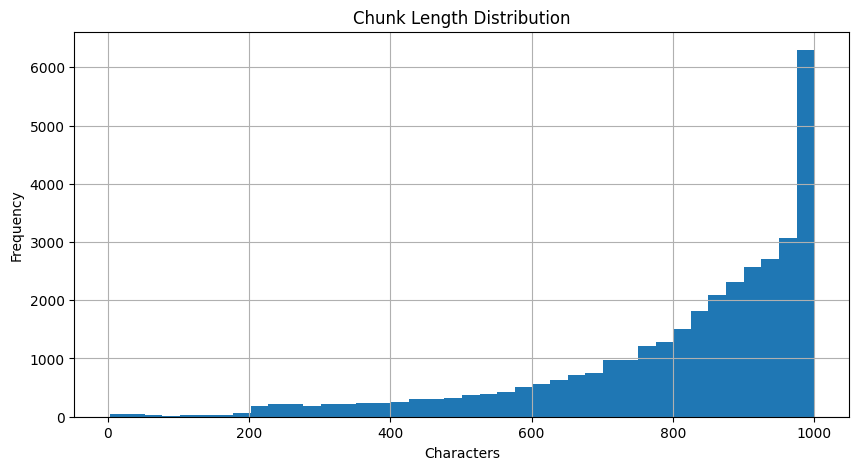

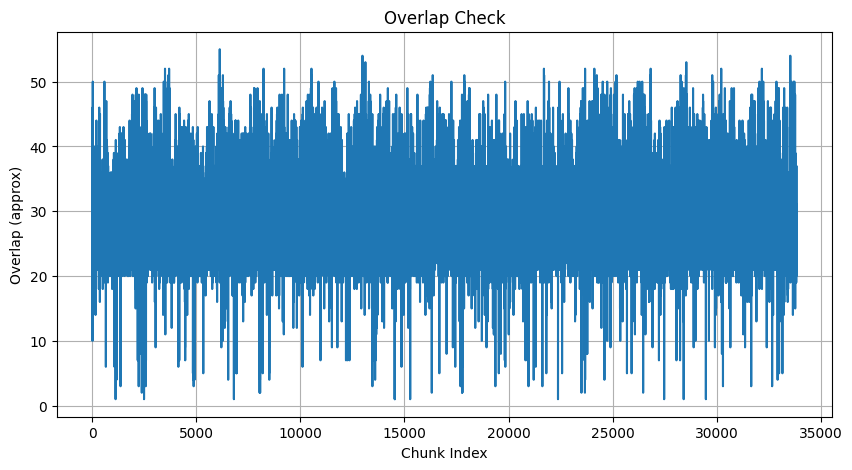


✅ Sentence-aware chunking pipeline complete (NO embeddings)


In [ ]:
import os
import json
import matplotlib.pyplot as plt
import textwrap
from langchain_text_splitters import RecursiveCharacterTextSplitter


# 1️ PATHS
input_folder = r"K:\Python\ClauseAI\data\transformed"
chunk_folder = r"K:\Python\ClauseAI\dataset\chunks"

os.makedirs(chunk_folder, exist_ok=True)

print("✓ Paths ready")

#
# 2️CHUNKING FUNCTION (SENTENCE-AWARE + OVERLAP)

def chunk_text(text, chunk_size=1000, chunk_overlap=200):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ". ", " "]
    )
    return splitter.split_text(text)


# 3.PROCESS ALL CONTRACTS

files = sorted([f for f in os.listdir(input_folder) if f.endswith("_cleaned.txt")])

if not files:
    raise FileNotFoundError("❌ No cleaned files found")

for idx, fname in enumerate(files, start=1):
    path = os.path.join(input_folder, fname)

    with open(path, "r", encoding="utf-8") as f:
        text = f.read()

    # ---- Chunking
    chunks = chunk_text(text)

    # ---- Save chunks
    chunk_out = f"contract_{idx:03d}_chunks.json"
    with open(os.path.join(chunk_folder, chunk_out), "w", encoding="utf-8") as f:
        json.dump(chunks, f, indent=2)

    print(f"✓ Processed → {chunk_out}")


# 4️ PREVIEW ONE CHUNK FILE

sample_file = os.listdir(chunk_folder)[0]
with open(os.path.join(chunk_folder, sample_file), "r", encoding="utf-8") as f:
    chunks = json.load(f)

print("\n📄 Preview")
print("File:", sample_file)
print("Total chunks:", len(chunks))
print(textwrap.shorten(chunks[0], 500))


# 5 VISUALIZATION – CHUNK LENGTH DISTRIBUTION

chunk_lengths = []
for f_name in os.listdir(chunk_folder):
    with open(os.path.join(chunk_folder, f_name), "r", encoding="utf-8") as f:
        chunk_lengths.extend([len(c) for c in json.load(f)])

plt.figure(figsize=(10, 5))
plt.hist(chunk_lengths, bins=40)
plt.title("Chunk Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# 6️ VISUALIZATION – OVERLAP CHECK

overlaps = []
for f_name in os.listdir(chunk_folder):
    with open(os.path.join(chunk_folder, f_name), "r", encoding="utf-8") as f:
        file_chunks = json.load(f)

    for i in range(1, len(file_chunks)):
        prev = file_chunks[i - 1][-200:]
        curr = file_chunks[i][:200]
        overlaps.append(len(set(prev) & set(curr)))

plt.figure(figsize=(10, 5))
plt.plot(overlaps)
plt.title("Overlap Check")
plt.xlabel("Chunk Index")
plt.ylabel("Overlap (approx)")
plt.grid(True)
plt.show()

print("\n✅ Sentence-aware chunking pipeline complete (NO embeddings)")


<h1>Chunk Embeddings & Vector Normalization using #Sentence transformer </h1>

✓ Paths ready
✓ Model loaded: sentence-transformers/all-MiniLM-L6-v2 (384 dims)
✓ Embedded → contract_001_embeddings.json
✓ Embedded → contract_002_embeddings.json
✓ Embedded → contract_003_embeddings.json
✓ Embedded → contract_004_embeddings.json
✓ Embedded → contract_005_embeddings.json
✓ Embedded → contract_006_embeddings.json
✓ Embedded → contract_007_embeddings.json
✓ Embedded → contract_008_embeddings.json
✓ Embedded → contract_009_embeddings.json
✓ Embedded → contract_010_embeddings.json
✓ Embedded → contract_011_embeddings.json
✓ Embedded → contract_012_embeddings.json
✓ Embedded → contract_013_embeddings.json
✓ Embedded → contract_014_embeddings.json
✓ Embedded → contract_015_embeddings.json
✓ Embedded → contract_016_embeddings.json
✓ Embedded → contract_017_embeddings.json
✓ Embedded → contract_018_embeddings.json
✓ Embedded → contract_019_embeddings.json
✓ Embedded → contract_020_embeddings.json

📄 Preview Embedding File
File: contract_001_embeddings.json
Total vectors: 37
E

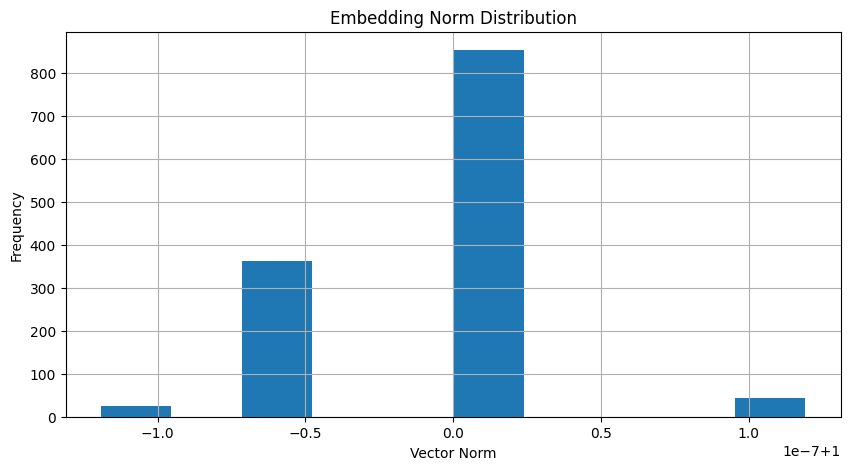


🧪 Similarity Sanity Check
Cosine Similarity : 0.7288
Dot Product      : 0.7288

✅ Embedding pipeline completed successfully


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1️⃣ IMPORTS & PATHS
chunk_folder = r"K:\Python\ClauseAI\dataset\chunks"
embed_folder = r"K:\Python\ClauseAI\dataset\embeddings"

os.makedirs(embed_folder, exist_ok=True)

print("✓ Paths ready")

# 2️⃣ LOAD SENTENCE TRANSFORMER MODEL
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME)

EMBED_DIM = model.get_sentence_embedding_dimension()
print(f"✓ Model loaded: {MODEL_NAME} ({EMBED_DIM} dims)")

# 3️⃣ EMBEDDING FUNCTION
def generate_embeddings(chunks, batch_size=64):
    return model.encode(
        chunks,
        batch_size=batch_size,
        show_progress_bar=False,
        normalize_embeddings=False
    )

# 4️⃣ PROCESS ALL CHUNK FILES (FIRST 20 FOR DEMO)
chunk_files = sorted(
    [f for f in os.listdir(chunk_folder) if f.endswith("_chunks.json")]
)[:20]

if not chunk_files:
    raise FileNotFoundError("❌ No chunk files found")

all_norms = []

for fname in chunk_files:
    with open(os.path.join(chunk_folder, fname), "r", encoding="utf-8") as f:
        chunks = json.load(f)

    embeddings = generate_embeddings(chunks)

    records = []
    for text, emb in zip(chunks, embeddings):
        norm = float(np.linalg.norm(emb))
        all_norms.append(norm)

        records.append({
            "text": text,
            "embedding": emb.tolist(),
            "norm": norm
        })

    out_name = fname.replace("_chunks.json", "_embeddings.json")
    with open(os.path.join(embed_folder, out_name), "w", encoding="utf-8") as f:
        json.dump(records, f, indent=2)

    print(f"✓ Embedded → {out_name}")

# 5️⃣ PREVIEW ONE EMBEDDING FILE
sample_file = sorted(os.listdir(embed_folder))[0]
with open(os.path.join(embed_folder, sample_file), "r", encoding="utf-8") as f:
    sample_data = json.load(f)

print("\n📄 Preview Embedding File")
print("File:", sample_file)
print("Total vectors:", len(sample_data))
print("Embedding length:", len(sample_data[0]["embedding"]))

# 6️⃣ VECTOR LENGTH CHECK
lengths = {len(item["embedding"]) for item in sample_data}
print("\n📐 Vector Length Check")
print("Unique vector lengths:", lengths)

# 7️⃣ VISUALIZATION – EMBEDDING NORM DISTRIBUTION
plt.figure(figsize=(10, 5))
plt.hist(all_norms, bins=10)   # FIXED: safe bin count
plt.title("Embedding Norm Distribution")
plt.xlabel("Vector Norm")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 8️⃣ SANITY CHECK – SIMILARITY (COSINE & DOT PRODUCT)
v1 = np.array(sample_data[0]["embedding"])
v2 = np.array(sample_data[1]["embedding"])

cos_sim = cosine_similarity([v1], [v2])[0][0]
dot_sim = np.dot(v1, v2)

print("\n🧪 Similarity Sanity Check")
print(f"Cosine Similarity : {cos_sim:.4f}")
print(f"Dot Product      : {dot_sim:.4f}")

print("\n✅ Embedding pipeline completed successfully")


<h1 > Chunk Embeddings & Vector Normalization </h1>

✓ Paths ready
✓ Model loaded: sentence-transformers/all-MiniLM-L6-v2 (384 dims)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


✓ Embedded → contract_001_embeddings.json (37 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


✓ Embedded → contract_002_embeddings.json (38 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


✓ Embedded → contract_003_embeddings.json (16 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


✓ Embedded → contract_004_embeddings.json (113 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


✓ Embedded → contract_005_embeddings.json (29 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


✓ Embedded → contract_006_embeddings.json (125 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


✓ Embedded → contract_007_embeddings.json (33 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


✓ Embedded → contract_008_embeddings.json (21 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


✓ Embedded → contract_009_embeddings.json (17 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


✓ Embedded → contract_010_embeddings.json (17 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


✓ Embedded → contract_011_embeddings.json (159 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


✓ Embedded → contract_012_embeddings.json (90 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


✓ Embedded → contract_013_embeddings.json (93 chunks)


Batches: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


✓ Embedded → contract_014_embeddings.json (164 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


✓ Embedded → contract_015_embeddings.json (15 chunks)


Batches: 100%|██████████| 3/3 [00:09<00:00,  3.00s/it]


✓ Embedded → contract_016_embeddings.json (189 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


✓ Embedded → contract_017_embeddings.json (42 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


✓ Embedded → contract_018_embeddings.json (43 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


✓ Embedded → contract_019_embeddings.json (21 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


✓ Embedded → contract_020_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


✓ Embedded → contract_021_embeddings.json (55 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]


✓ Embedded → contract_022_embeddings.json (100 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


✓ Embedded → contract_023_embeddings.json (30 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


✓ Embedded → contract_024_embeddings.json (62 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


✓ Embedded → contract_025_embeddings.json (82 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


✓ Embedded → contract_026_embeddings.json (3 chunks)


Batches: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


✓ Embedded → contract_027_embeddings.json (200 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


✓ Embedded → contract_028_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


✓ Embedded → contract_029_embeddings.json (47 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


✓ Embedded → contract_030_embeddings.json (59 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


✓ Embedded → contract_031_embeddings.json (25 chunks)


Batches: 100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


✓ Embedded → contract_032_embeddings.json (226 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


✓ Embedded → contract_033_embeddings.json (47 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


✓ Embedded → contract_034_embeddings.json (50 chunks)


Batches: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


✓ Embedded → contract_035_embeddings.json (142 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


✓ Embedded → contract_036_embeddings.json (62 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


✓ Embedded → contract_037_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


✓ Embedded → contract_038_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


✓ Embedded → contract_039_embeddings.json (24 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


✓ Embedded → contract_040_embeddings.json (81 chunks)


Batches: 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


✓ Embedded → contract_041_embeddings.json (372 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


✓ Embedded → contract_042_embeddings.json (50 chunks)


Batches: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


✓ Embedded → contract_043_embeddings.json (305 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


✓ Embedded → contract_044_embeddings.json (102 chunks)


Batches: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


✓ Embedded → contract_045_embeddings.json (290 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


✓ Embedded → contract_046_embeddings.json (21 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


✓ Embedded → contract_047_embeddings.json (151 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


✓ Embedded → contract_048_embeddings.json (3 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


✓ Embedded → contract_049_embeddings.json (66 chunks)


Batches: 100%|██████████| 4/4 [00:13<00:00,  3.29s/it]


✓ Embedded → contract_050_embeddings.json (256 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


✓ Embedded → contract_051_embeddings.json (50 chunks)


Batches: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


✓ Embedded → contract_052_embeddings.json (280 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


✓ Embedded → contract_053_embeddings.json (65 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


✓ Embedded → contract_054_embeddings.json (78 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


✓ Embedded → contract_055_embeddings.json (48 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


✓ Embedded → contract_056_embeddings.json (8 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


✓ Embedded → contract_057_embeddings.json (105 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


✓ Embedded → contract_058_embeddings.json (83 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


✓ Embedded → contract_059_embeddings.json (48 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


✓ Embedded → contract_060_embeddings.json (23 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


✓ Embedded → contract_061_embeddings.json (2 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


✓ Embedded → contract_062_embeddings.json (73 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


✓ Embedded → contract_063_embeddings.json (45 chunks)


Batches: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]


✓ Embedded → contract_064_embeddings.json (184 chunks)


Batches: 100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


✓ Embedded → contract_065_embeddings.json (186 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


✓ Embedded → contract_066_embeddings.json (43 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


✓ Embedded → contract_067_embeddings.json (52 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


✓ Embedded → contract_068_embeddings.json (14 chunks)


Batches: 100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


✓ Embedded → contract_069_embeddings.json (218 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


✓ Embedded → contract_070_embeddings.json (26 chunks)


Batches: 100%|██████████| 3/3 [00:11<00:00,  3.70s/it]


✓ Embedded → contract_071_embeddings.json (192 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


✓ Embedded → contract_072_embeddings.json (54 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


✓ Embedded → contract_073_embeddings.json (3 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


✓ Embedded → contract_074_embeddings.json (11 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


✓ Embedded → contract_075_embeddings.json (2 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


✓ Embedded → contract_076_embeddings.json (38 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


✓ Embedded → contract_077_embeddings.json (31 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]


✓ Embedded → contract_078_embeddings.json (145 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


✓ Embedded → contract_079_embeddings.json (20 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


✓ Embedded → contract_080_embeddings.json (11 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


✓ Embedded → contract_081_embeddings.json (75 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


✓ Embedded → contract_082_embeddings.json (44 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


✓ Embedded → contract_083_embeddings.json (17 chunks)


Batches: 100%|██████████| 6/6 [00:18<00:00,  3.03s/it]


✓ Embedded → contract_084_embeddings.json (350 chunks)


Batches: 100%|██████████| 3/3 [00:10<00:00,  3.52s/it]


✓ Embedded → contract_085_embeddings.json (179 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


✓ Embedded → contract_086_embeddings.json (32 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


✓ Embedded → contract_087_embeddings.json (50 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


✓ Embedded → contract_088_embeddings.json (38 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


✓ Embedded → contract_089_embeddings.json (20 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


✓ Embedded → contract_090_embeddings.json (17 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


✓ Embedded → contract_091_embeddings.json (18 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


✓ Embedded → contract_092_embeddings.json (39 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


✓ Embedded → contract_093_embeddings.json (67 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


✓ Embedded → contract_094_embeddings.json (15 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


✓ Embedded → contract_095_embeddings.json (51 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


✓ Embedded → contract_096_embeddings.json (28 chunks)


Batches: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


✓ Embedded → contract_097_embeddings.json (214 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


✓ Embedded → contract_098_embeddings.json (4 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


✓ Embedded → contract_099_embeddings.json (3 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


✓ Embedded → contract_100_embeddings.json (7 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


✓ Embedded → contract_101_embeddings.json (42 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


✓ Embedded → contract_102_embeddings.json (85 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


✓ Embedded → contract_103_embeddings.json (14 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


✓ Embedded → contract_104_embeddings.json (68 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


✓ Embedded → contract_105_embeddings.json (44 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


✓ Embedded → contract_106_embeddings.json (29 chunks)


Batches: 100%|██████████| 3/3 [00:10<00:00,  3.54s/it]


✓ Embedded → contract_107_embeddings.json (186 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


✓ Embedded → contract_108_embeddings.json (63 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


✓ Embedded → contract_109_embeddings.json (83 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


✓ Embedded → contract_110_embeddings.json (36 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


✓ Embedded → contract_111_embeddings.json (42 chunks)


Batches: 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


✓ Embedded → contract_112_embeddings.json (216 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


✓ Embedded → contract_113_embeddings.json (94 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


✓ Embedded → contract_114_embeddings.json (16 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


✓ Embedded → contract_115_embeddings.json (9 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


✓ Embedded → contract_116_embeddings.json (41 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


✓ Embedded → contract_117_embeddings.json (46 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


✓ Embedded → contract_118_embeddings.json (63 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


✓ Embedded → contract_119_embeddings.json (57 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


✓ Embedded → contract_120_embeddings.json (33 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


✓ Embedded → contract_121_embeddings.json (13 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


✓ Embedded → contract_122_embeddings.json (37 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.43s/it]


✓ Embedded → contract_123_embeddings.json (144 chunks)


Batches: 100%|██████████| 4/4 [00:13<00:00,  3.45s/it]


✓ Embedded → contract_124_embeddings.json (230 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.33s/it]


✓ Embedded → contract_125_embeddings.json (108 chunks)


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


✓ Embedded → contract_126_embeddings.json (57 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


✓ Embedded → contract_127_embeddings.json (62 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


✓ Embedded → contract_128_embeddings.json (27 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.84s/it]


✓ Embedded → contract_129_embeddings.json (106 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


✓ Embedded → contract_130_embeddings.json (76 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


✓ Embedded → contract_131_embeddings.json (92 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


✓ Embedded → contract_132_embeddings.json (57 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


✓ Embedded → contract_133_embeddings.json (52 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


✓ Embedded → contract_134_embeddings.json (33 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


✓ Embedded → contract_135_embeddings.json (70 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


✓ Embedded → contract_136_embeddings.json (55 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


✓ Embedded → contract_137_embeddings.json (24 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


✓ Embedded → contract_138_embeddings.json (10 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.37s/it]


✓ Embedded → contract_139_embeddings.json (84 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


✓ Embedded → contract_140_embeddings.json (120 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


✓ Embedded → contract_141_embeddings.json (78 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


✓ Embedded → contract_142_embeddings.json (42 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


✓ Embedded → contract_143_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


✓ Embedded → contract_144_embeddings.json (23 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


✓ Embedded → contract_145_embeddings.json (92 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


✓ Embedded → contract_146_embeddings.json (43 chunks)


Batches: 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


✓ Embedded → contract_147_embeddings.json (213 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


✓ Embedded → contract_148_embeddings.json (7 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


✓ Embedded → contract_149_embeddings.json (21 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


✓ Embedded → contract_150_embeddings.json (8 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


✓ Embedded → contract_151_embeddings.json (15 chunks)


Batches: 100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


✓ Embedded → contract_152_embeddings.json (208 chunks)


Batches: 100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


✓ Embedded → contract_153_embeddings.json (175 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


✓ Embedded → contract_154_embeddings.json (26 chunks)


Batches: 100%|██████████| 4/4 [00:13<00:00,  3.28s/it]


✓ Embedded → contract_155_embeddings.json (221 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


✓ Embedded → contract_156_embeddings.json (49 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


✓ Embedded → contract_157_embeddings.json (53 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


✓ Embedded → contract_158_embeddings.json (37 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


✓ Embedded → contract_159_embeddings.json (8 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


✓ Embedded → contract_160_embeddings.json (35 chunks)


Batches: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


✓ Embedded → contract_161_embeddings.json (141 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


✓ Embedded → contract_162_embeddings.json (24 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


✓ Embedded → contract_163_embeddings.json (46 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


✓ Embedded → contract_164_embeddings.json (23 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


✓ Embedded → contract_165_embeddings.json (2 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


✓ Embedded → contract_166_embeddings.json (5 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


✓ Embedded → contract_167_embeddings.json (28 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


✓ Embedded → contract_168_embeddings.json (28 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


✓ Embedded → contract_169_embeddings.json (25 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.47s/it]


✓ Embedded → contract_170_embeddings.json (77 chunks)


Batches: 100%|██████████| 7/7 [00:23<00:00,  3.31s/it]


✓ Embedded → contract_171_embeddings.json (391 chunks)


Batches: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


✓ Embedded → contract_172_embeddings.json (284 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


✓ Embedded → contract_173_embeddings.json (7 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


✓ Embedded → contract_174_embeddings.json (50 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


✓ Embedded → contract_175_embeddings.json (47 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


✓ Embedded → contract_176_embeddings.json (20 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


✓ Embedded → contract_177_embeddings.json (37 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


✓ Embedded → contract_178_embeddings.json (78 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


✓ Embedded → contract_179_embeddings.json (35 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


✓ Embedded → contract_180_embeddings.json (53 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.57s/it]


✓ Embedded → contract_181_embeddings.json (144 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


✓ Embedded → contract_182_embeddings.json (15 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


✓ Embedded → contract_183_embeddings.json (4 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


✓ Embedded → contract_184_embeddings.json (2 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


✓ Embedded → contract_185_embeddings.json (51 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


✓ Embedded → contract_186_embeddings.json (62 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


✓ Embedded → contract_187_embeddings.json (75 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


✓ Embedded → contract_188_embeddings.json (37 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


✓ Embedded → contract_189_embeddings.json (4 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


✓ Embedded → contract_190_embeddings.json (39 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


✓ Embedded → contract_191_embeddings.json (77 chunks)


Batches: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


✓ Embedded → contract_192_embeddings.json (154 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


✓ Embedded → contract_193_embeddings.json (40 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.63s/it]


✓ Embedded → contract_194_embeddings.json (94 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


✓ Embedded → contract_195_embeddings.json (41 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


✓ Embedded → contract_196_embeddings.json (19 chunks)


Batches: 100%|██████████| 3/3 [00:09<00:00,  3.32s/it]


✓ Embedded → contract_197_embeddings.json (190 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


✓ Embedded → contract_198_embeddings.json (27 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


✓ Embedded → contract_199_embeddings.json (16 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


✓ Embedded → contract_200_embeddings.json (33 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


✓ Embedded → contract_201_embeddings.json (45 chunks)


Batches: 100%|██████████| 6/6 [00:16<00:00,  2.74s/it]


✓ Embedded → contract_202_embeddings.json (335 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


✓ Embedded → contract_203_embeddings.json (28 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


✓ Embedded → contract_204_embeddings.json (61 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


✓ Embedded → contract_205_embeddings.json (12 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


✓ Embedded → contract_206_embeddings.json (18 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


✓ Embedded → contract_207_embeddings.json (26 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


✓ Embedded → contract_208_embeddings.json (32 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.61s/it]


✓ Embedded → contract_209_embeddings.json (101 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


✓ Embedded → contract_210_embeddings.json (96 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


✓ Embedded → contract_211_embeddings.json (27 chunks)


Batches: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


✓ Embedded → contract_212_embeddings.json (205 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


✓ Embedded → contract_213_embeddings.json (81 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


✓ Embedded → contract_214_embeddings.json (88 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


✓ Embedded → contract_215_embeddings.json (83 chunks)


Batches: 100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


✓ Embedded → contract_216_embeddings.json (261 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


✓ Embedded → contract_217_embeddings.json (10 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


✓ Embedded → contract_218_embeddings.json (136 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


✓ Embedded → contract_219_embeddings.json (49 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


✓ Embedded → contract_220_embeddings.json (65 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


✓ Embedded → contract_221_embeddings.json (92 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.18s/it]


✓ Embedded → contract_222_embeddings.json (128 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


✓ Embedded → contract_223_embeddings.json (28 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


✓ Embedded → contract_224_embeddings.json (39 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


✓ Embedded → contract_225_embeddings.json (44 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


✓ Embedded → contract_226_embeddings.json (54 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


✓ Embedded → contract_227_embeddings.json (44 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


✓ Embedded → contract_228_embeddings.json (16 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


✓ Embedded → contract_229_embeddings.json (62 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


✓ Embedded → contract_230_embeddings.json (52 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


✓ Embedded → contract_231_embeddings.json (29 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


✓ Embedded → contract_232_embeddings.json (33 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


✓ Embedded → contract_233_embeddings.json (28 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


✓ Embedded → contract_234_embeddings.json (126 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]


✓ Embedded → contract_235_embeddings.json (92 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


✓ Embedded → contract_236_embeddings.json (19 chunks)


Batches: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


✓ Embedded → contract_237_embeddings.json (213 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


✓ Embedded → contract_238_embeddings.json (95 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


✓ Embedded → contract_239_embeddings.json (23 chunks)


Batches: 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


✓ Embedded → contract_240_embeddings.json (225 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


✓ Embedded → contract_241_embeddings.json (48 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


✓ Embedded → contract_242_embeddings.json (23 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


✓ Embedded → contract_243_embeddings.json (19 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


✓ Embedded → contract_244_embeddings.json (34 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


✓ Embedded → contract_245_embeddings.json (10 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


✓ Embedded → contract_246_embeddings.json (76 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


✓ Embedded → contract_247_embeddings.json (29 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


✓ Embedded → contract_248_embeddings.json (16 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


✓ Embedded → contract_249_embeddings.json (48 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


✓ Embedded → contract_250_embeddings.json (24 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


✓ Embedded → contract_251_embeddings.json (50 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


✓ Embedded → contract_252_embeddings.json (24 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


✓ Embedded → contract_253_embeddings.json (37 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


✓ Embedded → contract_254_embeddings.json (119 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


✓ Embedded → contract_255_embeddings.json (19 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


✓ Embedded → contract_256_embeddings.json (69 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


✓ Embedded → contract_257_embeddings.json (26 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


✓ Embedded → contract_258_embeddings.json (62 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


✓ Embedded → contract_259_embeddings.json (64 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


✓ Embedded → contract_260_embeddings.json (3 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


✓ Embedded → contract_261_embeddings.json (14 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


✓ Embedded → contract_262_embeddings.json (25 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.16s/it]


✓ Embedded → contract_263_embeddings.json (114 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


✓ Embedded → contract_264_embeddings.json (14 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


✓ Embedded → contract_265_embeddings.json (47 chunks)


Batches: 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


✓ Embedded → contract_266_embeddings.json (218 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

✓ Embedded → contract_267_embeddings.json (2 chunks)



Batches: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


✓ Embedded → contract_268_embeddings.json (19 chunks)


Batches: 100%|██████████| 6/6 [00:20<00:00,  3.35s/it]


✓ Embedded → contract_269_embeddings.json (357 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


✓ Embedded → contract_270_embeddings.json (15 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


✓ Embedded → contract_271_embeddings.json (20 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


✓ Embedded → contract_272_embeddings.json (32 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


✓ Embedded → contract_273_embeddings.json (61 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


✓ Embedded → contract_274_embeddings.json (83 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


✓ Embedded → contract_275_embeddings.json (27 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


✓ Embedded → contract_276_embeddings.json (28 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


✓ Embedded → contract_277_embeddings.json (5 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


✓ Embedded → contract_278_embeddings.json (76 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


✓ Embedded → contract_279_embeddings.json (29 chunks)


Batches: 100%|██████████| 3/3 [00:08<00:00,  2.77s/it]


✓ Embedded → contract_280_embeddings.json (168 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


✓ Embedded → contract_281_embeddings.json (28 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


✓ Embedded → contract_282_embeddings.json (21 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


✓ Embedded → contract_283_embeddings.json (74 chunks)


Batches: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


✓ Embedded → contract_284_embeddings.json (297 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


✓ Embedded → contract_285_embeddings.json (16 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


✓ Embedded → contract_286_embeddings.json (43 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


✓ Embedded → contract_287_embeddings.json (97 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.59s/it]


✓ Embedded → contract_288_embeddings.json (158 chunks)


Batches: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]


✓ Embedded → contract_289_embeddings.json (250 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


✓ Embedded → contract_290_embeddings.json (43 chunks)


Batches: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


✓ Embedded → contract_291_embeddings.json (300 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


✓ Embedded → contract_292_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


✓ Embedded → contract_293_embeddings.json (10 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


✓ Embedded → contract_294_embeddings.json (116 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


✓ Embedded → contract_295_embeddings.json (45 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


✓ Embedded → contract_296_embeddings.json (64 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


✓ Embedded → contract_297_embeddings.json (36 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


✓ Embedded → contract_298_embeddings.json (2 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


✓ Embedded → contract_299_embeddings.json (44 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


✓ Embedded → contract_300_embeddings.json (24 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


✓ Embedded → contract_301_embeddings.json (75 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


✓ Embedded → contract_302_embeddings.json (5 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


✓ Embedded → contract_303_embeddings.json (8 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


✓ Embedded → contract_304_embeddings.json (50 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


✓ Embedded → contract_305_embeddings.json (43 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


✓ Embedded → contract_306_embeddings.json (4 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]


✓ Embedded → contract_307_embeddings.json (158 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.58s/it]


✓ Embedded → contract_308_embeddings.json (158 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


✓ Embedded → contract_309_embeddings.json (31 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


✓ Embedded → contract_310_embeddings.json (99 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


✓ Embedded → contract_311_embeddings.json (9 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


✓ Embedded → contract_312_embeddings.json (62 chunks)


Batches: 100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


✓ Embedded → contract_313_embeddings.json (118 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


✓ Embedded → contract_314_embeddings.json (27 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


✓ Embedded → contract_315_embeddings.json (92 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


✓ Embedded → contract_316_embeddings.json (23 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


✓ Embedded → contract_317_embeddings.json (28 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


✓ Embedded → contract_318_embeddings.json (72 chunks)


Batches: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


✓ Embedded → contract_319_embeddings.json (198 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


✓ Embedded → contract_320_embeddings.json (133 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


✓ Embedded → contract_321_embeddings.json (7 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


✓ Embedded → contract_322_embeddings.json (34 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


✓ Embedded → contract_323_embeddings.json (73 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


✓ Embedded → contract_324_embeddings.json (18 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


✓ Embedded → contract_325_embeddings.json (8 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


✓ Embedded → contract_326_embeddings.json (29 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


✓ Embedded → contract_327_embeddings.json (12 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


✓ Embedded → contract_328_embeddings.json (24 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


✓ Embedded → contract_329_embeddings.json (89 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


✓ Embedded → contract_330_embeddings.json (5 chunks)


Batches: 100%|██████████| 3/3 [00:10<00:00,  3.48s/it]


✓ Embedded → contract_331_embeddings.json (187 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


✓ Embedded → contract_332_embeddings.json (31 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


✓ Embedded → contract_333_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


✓ Embedded → contract_334_embeddings.json (20 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


✓ Embedded → contract_335_embeddings.json (129 chunks)


Batches: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]


✓ Embedded → contract_336_embeddings.json (157 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


✓ Embedded → contract_337_embeddings.json (31 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


✓ Embedded → contract_338_embeddings.json (1 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


✓ Embedded → contract_339_embeddings.json (30 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


✓ Embedded → contract_340_embeddings.json (6 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


✓ Embedded → contract_341_embeddings.json (87 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


✓ Embedded → contract_342_embeddings.json (17 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


✓ Embedded → contract_343_embeddings.json (24 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


✓ Embedded → contract_344_embeddings.json (21 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


✓ Embedded → contract_345_embeddings.json (94 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


✓ Embedded → contract_346_embeddings.json (114 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


✓ Embedded → contract_347_embeddings.json (153 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


✓ Embedded → contract_348_embeddings.json (86 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


✓ Embedded → contract_349_embeddings.json (24 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


✓ Embedded → contract_350_embeddings.json (1 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


✓ Embedded → contract_351_embeddings.json (3 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


✓ Embedded → contract_352_embeddings.json (23 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


✓ Embedded → contract_353_embeddings.json (43 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


✓ Embedded → contract_354_embeddings.json (70 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


✓ Embedded → contract_355_embeddings.json (35 chunks)


Batches: 100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


✓ Embedded → contract_356_embeddings.json (194 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


✓ Embedded → contract_357_embeddings.json (10 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


✓ Embedded → contract_358_embeddings.json (22 chunks)


Batches: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it]


✓ Embedded → contract_359_embeddings.json (404 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


✓ Embedded → contract_360_embeddings.json (31 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


✓ Embedded → contract_361_embeddings.json (35 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.61s/it]


✓ Embedded → contract_362_embeddings.json (156 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


✓ Embedded → contract_363_embeddings.json (5 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


✓ Embedded → contract_364_embeddings.json (8 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


✓ Embedded → contract_365_embeddings.json (37 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


✓ Embedded → contract_366_embeddings.json (19 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


✓ Embedded → contract_367_embeddings.json (4 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


✓ Embedded → contract_368_embeddings.json (35 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


✓ Embedded → contract_369_embeddings.json (30 chunks)


Batches: 100%|██████████| 3/3 [00:10<00:00,  3.42s/it]


✓ Embedded → contract_370_embeddings.json (153 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


✓ Embedded → contract_371_embeddings.json (72 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


✓ Embedded → contract_372_embeddings.json (18 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


✓ Embedded → contract_373_embeddings.json (21 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


✓ Embedded → contract_374_embeddings.json (1 chunks)


Batches: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


✓ Embedded → contract_375_embeddings.json (172 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


✓ Embedded → contract_376_embeddings.json (54 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


✓ Embedded → contract_377_embeddings.json (51 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


✓ Embedded → contract_378_embeddings.json (56 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


✓ Embedded → contract_379_embeddings.json (130 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


✓ Embedded → contract_380_embeddings.json (45 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


✓ Embedded → contract_381_embeddings.json (39 chunks)


Batches: 100%|██████████| 3/3 [00:06<00:00,  2.27s/it]


✓ Embedded → contract_382_embeddings.json (148 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


✓ Embedded → contract_383_embeddings.json (79 chunks)


Batches: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]


✓ Embedded → contract_384_embeddings.json (360 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


✓ Embedded → contract_385_embeddings.json (82 chunks)


Batches: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


✓ Embedded → contract_386_embeddings.json (149 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


✓ Embedded → contract_387_embeddings.json (6 chunks)


Batches: 100%|██████████| 3/3 [00:09<00:00,  3.16s/it]


✓ Embedded → contract_388_embeddings.json (162 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.50s/it]


✓ Embedded → contract_389_embeddings.json (93 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


✓ Embedded → contract_390_embeddings.json (12 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


✓ Embedded → contract_391_embeddings.json (98 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


✓ Embedded → contract_392_embeddings.json (12 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.79s/it]


✓ Embedded → contract_393_embeddings.json (105 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


✓ Embedded → contract_394_embeddings.json (25 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


✓ Embedded → contract_395_embeddings.json (66 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


✓ Embedded → contract_396_embeddings.json (11 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


✓ Embedded → contract_397_embeddings.json (44 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


✓ Embedded → contract_398_embeddings.json (32 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


✓ Embedded → contract_399_embeddings.json (116 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


✓ Embedded → contract_400_embeddings.json (12 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


✓ Embedded → contract_401_embeddings.json (35 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


✓ Embedded → contract_402_embeddings.json (33 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


✓ Embedded → contract_403_embeddings.json (16 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


✓ Embedded → contract_404_embeddings.json (69 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


✓ Embedded → contract_405_embeddings.json (3 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


✓ Embedded → contract_406_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


✓ Embedded → contract_407_embeddings.json (12 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


✓ Embedded → contract_408_embeddings.json (2 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


✓ Embedded → contract_409_embeddings.json (47 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


✓ Embedded → contract_410_embeddings.json (123 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


✓ Embedded → contract_411_embeddings.json (35 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


✓ Embedded → contract_412_embeddings.json (86 chunks)


Batches: 100%|██████████| 2/2 [00:07<00:00,  3.61s/it]


✓ Embedded → contract_413_embeddings.json (125 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


✓ Embedded → contract_414_embeddings.json (42 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


✓ Embedded → contract_415_embeddings.json (15 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


✓ Embedded → contract_416_embeddings.json (4 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


✓ Embedded → contract_417_embeddings.json (17 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


✓ Embedded → contract_418_embeddings.json (110 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


✓ Embedded → contract_419_embeddings.json (16 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


✓ Embedded → contract_420_embeddings.json (15 chunks)


Batches: 100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


✓ Embedded → contract_421_embeddings.json (193 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


✓ Embedded → contract_422_embeddings.json (29 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


✓ Embedded → contract_423_embeddings.json (38 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


✓ Embedded → contract_424_embeddings.json (53 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


✓ Embedded → contract_425_embeddings.json (138 chunks)


Batches: 100%|██████████| 3/3 [00:09<00:00,  3.06s/it]


✓ Embedded → contract_426_embeddings.json (187 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


✓ Embedded → contract_427_embeddings.json (7 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


✓ Embedded → contract_428_embeddings.json (4 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


✓ Embedded → contract_429_embeddings.json (5 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


✓ Embedded → contract_430_embeddings.json (30 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


✓ Embedded → contract_431_embeddings.json (68 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]


✓ Embedded → contract_432_embeddings.json (101 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


✓ Embedded → contract_433_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


✓ Embedded → contract_434_embeddings.json (41 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


✓ Embedded → contract_435_embeddings.json (5 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


✓ Embedded → contract_436_embeddings.json (32 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


✓ Embedded → contract_437_embeddings.json (124 chunks)


Batches: 100%|██████████| 2/2 [00:07<00:00,  3.60s/it]


✓ Embedded → contract_438_embeddings.json (126 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


✓ Embedded → contract_439_embeddings.json (43 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


✓ Embedded → contract_440_embeddings.json (10 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


✓ Embedded → contract_441_embeddings.json (8 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


✓ Embedded → contract_442_embeddings.json (122 chunks)


Batches: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


✓ Embedded → contract_443_embeddings.json (126 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


✓ Embedded → contract_444_embeddings.json (19 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


✓ Embedded → contract_445_embeddings.json (58 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


✓ Embedded → contract_446_embeddings.json (24 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


✓ Embedded → contract_447_embeddings.json (17 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


✓ Embedded → contract_448_embeddings.json (8 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


✓ Embedded → contract_449_embeddings.json (60 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


✓ Embedded → contract_450_embeddings.json (7 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


✓ Embedded → contract_451_embeddings.json (43 chunks)


Batches: 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


✓ Embedded → contract_452_embeddings.json (155 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]


✓ Embedded → contract_453_embeddings.json (95 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


✓ Embedded → contract_454_embeddings.json (24 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


✓ Embedded → contract_455_embeddings.json (18 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


✓ Embedded → contract_456_embeddings.json (3 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


✓ Embedded → contract_457_embeddings.json (49 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


✓ Embedded → contract_458_embeddings.json (69 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


✓ Embedded → contract_459_embeddings.json (17 chunks)


Batches: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


✓ Embedded → contract_460_embeddings.json (311 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


✓ Embedded → contract_461_embeddings.json (32 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


✓ Embedded → contract_462_embeddings.json (89 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


✓ Embedded → contract_463_embeddings.json (98 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


✓ Embedded → contract_464_embeddings.json (21 chunks)


Batches: 100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


✓ Embedded → contract_465_embeddings.json (135 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


✓ Embedded → contract_466_embeddings.json (11 chunks)


Batches: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it]


✓ Embedded → contract_467_embeddings.json (139 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


✓ Embedded → contract_468_embeddings.json (7 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


✓ Embedded → contract_469_embeddings.json (74 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.54s/it]


✓ Embedded → contract_470_embeddings.json (89 chunks)


Batches: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


✓ Embedded → contract_471_embeddings.json (70 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


✓ Embedded → contract_472_embeddings.json (2 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


✓ Embedded → contract_473_embeddings.json (59 chunks)


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


✓ Embedded → contract_474_embeddings.json (63 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


✓ Embedded → contract_475_embeddings.json (73 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


✓ Embedded → contract_476_embeddings.json (4 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


✓ Embedded → contract_477_embeddings.json (27 chunks)


Batches: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


✓ Embedded → contract_478_embeddings.json (390 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


✓ Embedded → contract_479_embeddings.json (58 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


✓ Embedded → contract_480_embeddings.json (18 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


✓ Embedded → contract_481_embeddings.json (46 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


✓ Embedded → contract_482_embeddings.json (61 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


✓ Embedded → contract_483_embeddings.json (13 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


✓ Embedded → contract_484_embeddings.json (33 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


✓ Embedded → contract_485_embeddings.json (38 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


✓ Embedded → contract_486_embeddings.json (53 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


✓ Embedded → contract_487_embeddings.json (24 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


✓ Embedded → contract_488_embeddings.json (48 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


✓ Embedded → contract_489_embeddings.json (21 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


✓ Embedded → contract_490_embeddings.json (90 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


✓ Embedded → contract_491_embeddings.json (9 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


✓ Embedded → contract_492_embeddings.json (39 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


✓ Embedded → contract_493_embeddings.json (94 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


✓ Embedded → contract_494_embeddings.json (93 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


✓ Embedded → contract_495_embeddings.json (3 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


✓ Embedded → contract_496_embeddings.json (61 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


✓ Embedded → contract_497_embeddings.json (20 chunks)


Batches: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


✓ Embedded → contract_498_embeddings.json (106 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


✓ Embedded → contract_499_embeddings.json (16 chunks)


Batches: 100%|██████████| 3/3 [00:09<00:00,  3.26s/it]


✓ Embedded → contract_500_embeddings.json (164 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


✓ Embedded → contract_501_embeddings.json (9 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


✓ Embedded → contract_502_embeddings.json (22 chunks)


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


✓ Embedded → contract_503_embeddings.json (56 chunks)


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


✓ Embedded → contract_504_embeddings.json (23 chunks)


Batches: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


✓ Embedded → contract_505_embeddings.json (74 chunks)


Batches: 100%|██████████| 3/3 [00:09<00:00,  3.13s/it]


✓ Embedded → contract_506_embeddings.json (176 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


✓ Embedded → contract_507_embeddings.json (13 chunks)


Batches: 100%|██████████| 4/4 [00:13<00:00,  3.25s/it]


✓ Embedded → contract_508_embeddings.json (245 chunks)


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


✓ Embedded → contract_509_embeddings.json (58 chunks)


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


✓ Embedded → contract_510_embeddings.json (11 chunks)

🔢 TOTAL CHUNKS EMBEDDED: 34346

📄 Preview Embedding File
File: contract_001_embeddings.json
Total vectors: 37
Embedding length: 384

📐 Vector Length Check
Unique vector lengths: {384}


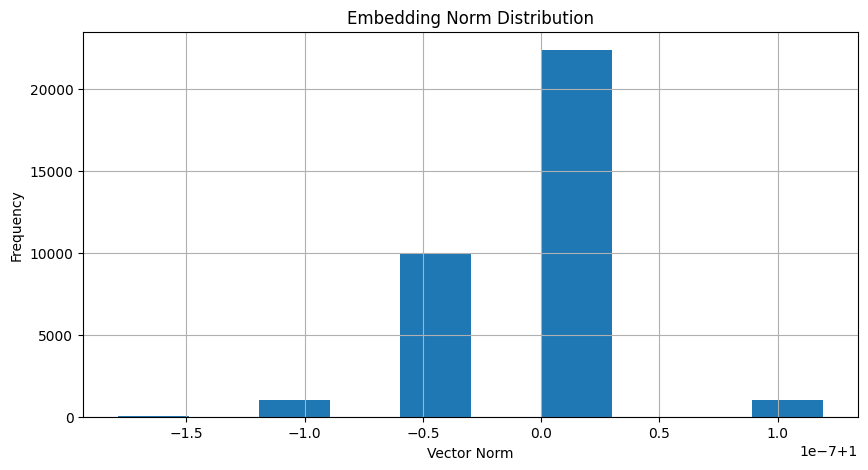


🧪 Similarity Sanity Check
Cosine Similarity : 0.7288
Dot Product      : 0.7288

✅ All contract chunks embedded successfully


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1️⃣ IMPORTS & PATHS
chunk_folder = r"K:\Python\ClauseAI\dataset\chunks"
embed_folder = r"K:\Python\ClauseAI\dataset\embeddings"

os.makedirs(embed_folder, exist_ok=True)

print("✓ Paths ready")

# 2️⃣ LOAD SENTENCE TRANSFORMER MODEL
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME)

EMBED_DIM = model.get_sentence_embedding_dimension()
print(f"✓ Model loaded: {MODEL_NAME} ({EMBED_DIM} dims)")

# 3️⃣ EMBEDDING FUNCTION
def generate_embeddings(chunks, batch_size=64):
    return model.encode(
        chunks,
        batch_size=batch_size,
        show_progress_bar=True,
        normalize_embeddings=False
    )

# 4️⃣ PROCESS ALL CHUNK FILES
chunk_files = sorted(
    f for f in os.listdir(chunk_folder) if f.endswith("_chunks.json")
)

if not chunk_files:
    raise FileNotFoundError("❌ No chunk files found")

all_norms = []
total_chunks = 0

for fname in chunk_files:
    with open(os.path.join(chunk_folder, fname), "r", encoding="utf-8") as f:
        chunks = json.load(f)

    total_chunks += len(chunks)

    embeddings = generate_embeddings(chunks)

    records = []
    for text, emb in zip(chunks, embeddings):
        norm = float(np.linalg.norm(emb))
        all_norms.append(norm)

        records.append({
            "text": text,
            "embedding": emb.tolist(),
            "norm": norm
        })

    out_name = fname.replace("_chunks.json", "_embeddings.json")
    with open(os.path.join(embed_folder, out_name), "w", encoding="utf-8") as f:
        json.dump(records, f, indent=2)

    print(f"✓ Embedded → {out_name} ({len(chunks)} chunks)")

print(f"\n🔢 TOTAL CHUNKS EMBEDDED: {total_chunks}")

# 5️⃣ PREVIEW ONE EMBEDDING FILE
sample_file = sorted(os.listdir(embed_folder))[0]
with open(os.path.join(embed_folder, sample_file), "r", encoding="utf-8") as f:
    sample_data = json.load(f)

print("\n📄 Preview Embedding File")
print("File:", sample_file)
print("Total vectors:", len(sample_data))
print("Embedding length:", len(sample_data[0]["embedding"]))

# 6️⃣ VECTOR LENGTH CHECK
lengths = {len(item["embedding"]) for item in sample_data}
print("\n📐 Vector Length Check")
print("Unique vector lengths:", lengths)

# 7️⃣ VISUALIZATION – EMBEDDING NORM DISTRIBUTION
plt.figure(figsize=(10, 5))
plt.hist(all_norms, bins=10)
plt.title("Embedding Norm Distribution")
plt.xlabel("Vector Norm")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 8️⃣ SANITY CHECK – SIMILARITY (COSINE & DOT PRODUCT)
v1 = np.array(sample_data[0]["embedding"])
v2 = np.array(sample_data[1]["embedding"])

cos_sim = cosine_similarity([v1], [v2])[0][0]
dot_sim = np.dot(v1, v2)

print("\n🧪 Similarity Sanity Check")
print(f"Cosine Similarity : {cos_sim:.4f}")
print(f"Dot Product      : {dot_sim:.4f}")

print("\n✅ All contract chunks embedded successfully")


#Next part - visualization

✓ Using embeddings from: K:\Python\ClauseAI\dataset\embeddings

📄 Preview One Embedding File
File: contract_001_embeddings.json
Total vectors: 37
Embedding dimension: 384
Sample text snippet:
CO-BRANDING AND ADVERTISING AGREEMENT THIS CO-BRANDING AND ADVERTISING AGREEMENT (the Agreement) is made as of June 21, 1999 (the Effective Date) by and between I-ESCROW, INC., with its principal place of business at 1730 S. Amphlett Blvd., Suite 233, San Mateo, California 94402 (i-Escrow), and 2THE ...

📐 Vector Length Check
Unique vector lengths across dataset: {384}


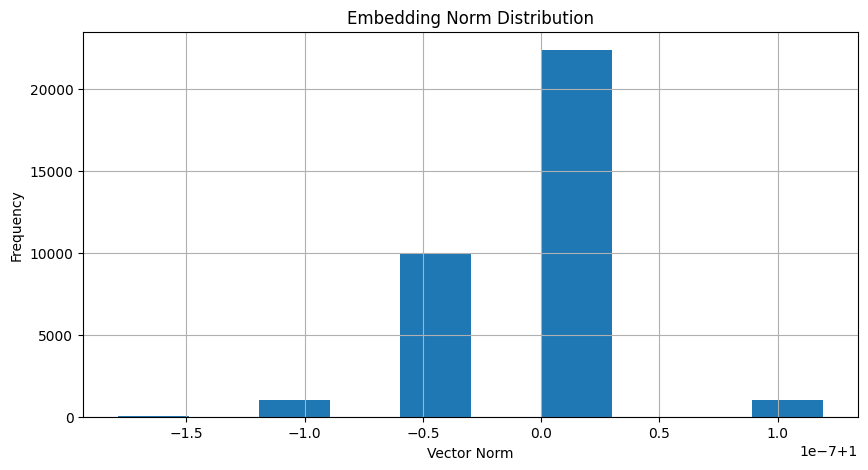


🧪 Similarity Sanity Check
Cosine Similarity : 0.7288
Dot Product      : 0.7288

✅ Embedding inspection & sanity checks complete


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


# 1️ PATHS

embed_folder = r"K:\Python\ClauseAI\dataset\embeddings"

print("✓ Using embeddings from:", embed_folder)

# 2️ LOAD ONE EMBEDDING FILE (PREVIEW)
embedding_files = sorted(
    f for f in os.listdir(embed_folder) if f.endswith("_embeddings.json")
)

if not embedding_files:
    raise FileNotFoundError("❌ No embedding files found")

sample_file = embedding_files[0]

with open(os.path.join(embed_folder, sample_file), "r", encoding="utf-8") as f:
    sample_data = json.load(f)

print("\n📄 Preview One Embedding File")
print("File:", sample_file)
print("Total vectors:", len(sample_data))
print("Embedding dimension:", len(sample_data[0]["embedding"]))
print("Sample text snippet:")
print(sample_data[0]["text"][:300], "...")


# 3️ VECTOR LENGTH CHECK

vector_lengths = set()

for fname in embedding_files:
    with open(os.path.join(embed_folder, fname), "r", encoding="utf-8") as f:
        data = json.load(f)
        for item in data:
            vector_lengths.add(len(item["embedding"]))

print("\n📐 Vector Length Check")
print("Unique vector lengths across dataset:", vector_lengths)


# 4️ COLLECT ALL EMBEDDING NORMS

all_norms = []

for fname in embedding_files:
    with open(os.path.join(embed_folder, fname), "r", encoding="utf-8") as f:
        data = json.load(f)
        for item in data:
            all_norms.append(item["norm"])


# 5️VISUALIZATION – EMBEDDING NORM DISTRIBUTION

plt.figure(figsize=(10, 5))
plt.hist(all_norms, bins=10)
plt.title("Embedding Norm Distribution")
plt.xlabel("Vector Norm")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# 6️ SANITY CHECK – SIMILARITY (COSINE & DOT PRODUCT)

vec1 = np.array(sample_data[0]["embedding"])
vec2 = np.array(sample_data[1]["embedding"])

cos_sim = cosine_similarity([vec1], [vec2])[0][0]
dot_sim = np.dot(vec1, vec2)

print("\n🧪 Similarity Sanity Check")
print(f"Cosine Similarity : {cos_sim:.4f}")
print(f"Dot Product      : {dot_sim:.4f}")

print("\n✅ Embedding inspection & sanity checks complete")


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install -U pinecone-client sentence-transformers matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 91.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [2]:
!pip uninstall -y pinecone-client


Found existing installation: pinecone-client 6.0.0
Uninstalling pinecone-client-6.0.0:
  Successfully uninstalled pinecone-client-6.0.0


In [3]:
!pip install -U pinecone sentence-transformers matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.9/745.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.9/280.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0


✓ Pinecone client initialized
✓ Index already exists
✓ Connected to index: pinevs
✓ Found 510 embedding files
✓ Prepared 20 vectors for upsert
✅ Vector upserted successfully (check web UI under __default__)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


🔍 QUERY: termination clause and contract cancellation

🏆 TOP 10 MATCHES:

1. ID: contract_386_embeddings.json_chunk_48, Score: 0.6946
   Text: . Section 6.4 Effect of Termination...
--------------------------------------------------------------------------------
2. ID: contract_139_embeddings.json_chunk_34, Score: 0.6889
   Text: . Such termination shall be in addition to any and all other actions or remedies the parties may seek at law or equity with respect to a breach of this Agreement. 10.3 Effect of Termination...
--------------------------------------------------------------------------------
3. ID: contract_230_embeddings.json_chunk_31, Score: 0.6816
   Text: . 16. Effect of Termination 16.1 in the case of termination, unless otherwise stipulated and subject to Customer fulfillments of all its payments obligations under this Agreement, Contractor will deliver all Products, materials to Customer and Customer will pay all amounts due under this Agreement, ...
--------------------

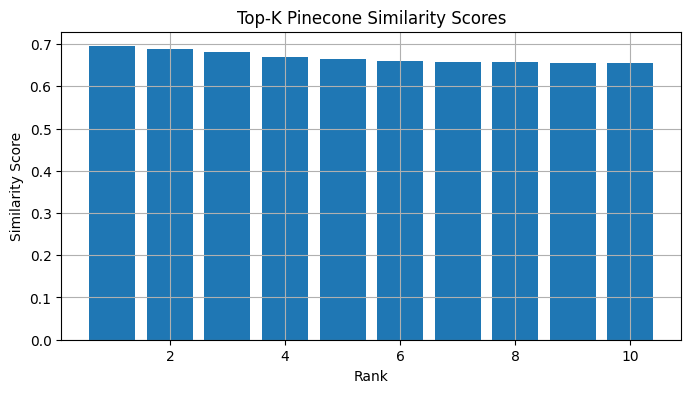


✅ Pipeline completed. Visit Pinecone web UI to see vectors!


In [1]:
# =============================================================
# PINECONE: CONNECT TO INDEX, UPSERT VECTORS, AND QUERY
# =============================================================

import os
import json
import uuid
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone, ServerlessSpec

# PINECONE INITIALIZATION
# -------------------------------------------------------------
PINECONE_API_KEY = "pcsk_6jbLBU_DxNgioCN5BHBNM6x3S2Gd9WMY3DDVnruCFBSsEa7efABnmRWydJhEn4itJDVfG"
PINECONE_ENV = "us-east-1"
INDEX_NAME = "pinevs"

# Initialize client
pc = Pinecone(api_key=PINECONE_API_KEY)
print("✓ Pinecone client initialized")

# CONNECT TO INDEX
EMBED_DIM = 384  # MiniLM dimension

if INDEX_NAME not in pc.list_indexes().names():
    print(" Creating Pinecone index...")
    pc.create_index(
        name=INDEX_NAME,
        dimension=EMBED_DIM,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region=PINECONE_ENV)
    )
else:
    print("✓ Index already exists")

index = pc.Index(INDEX_NAME)
print(f"✓ Connected to index: {INDEX_NAME}")

# 3️.LOAD EMBEDDINGS
embed_folder = "/content/drive/MyDrive/ClauseAI/dataset/embeddings"
embedding_files = sorted(f for f in os.listdir(embed_folder) if f.endswith("_embeddings.json"))

if not embedding_files:
    raise FileNotFoundError("❌ No embedding files found")
print(f"✓ Found {len(embedding_files)} embedding files")

# 4️. BUILD VECTORS FOR UPSERT
vectors = []
MAX_CONTRACTS = 20

for fname in embedding_files:
    with open(os.path.join(embed_folder, fname), "r", encoding="utf-8") as f:
        records = json.load(f)

    for i, rec in enumerate(records, start=1):
        vector_id = f"demo-visible-vector-{i}"  # readable in web UI
        vectors.append({
            "id": vector_id,
            "values": rec["embedding"],  # must be 384-dim
            "metadata": {"text": rec["text"], "source_file": fname}
        })

        if len(vectors) >= MAX_CONTRACTS:
            break
    if len(vectors) >= MAX_CONTRACTS:
        break

print(f"✓ Prepared {len(vectors)} vectors for upsert")

# 5️⃣ UPSERT VECTORS
index.upsert(vectors=vectors, namespace="__default__")
print("✅ Vector upserted successfully (check web UI under __default__)")

# 6️⃣ TEST QUERY (SEMANTIC SEARCH)
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME)

query_text = "termination clause and contract cancellation"
query_embedding = model.encode(query_text).tolist()

results = index.query(
    vector=query_embedding,
    top_k=10,
    include_metadata=True,
    namespace="__default__"
)

# 7️⃣ PRINT TOP-10 RESULTS
print("\n🔍 QUERY:", query_text)
print("\n🏆 TOP 10 MATCHES:\n")
scores = []

for i, match in enumerate(results["matches"], start=1):
    scores.append(match["score"])
    print(f"{i}. ID: {match['id']}, Score: {match['score']:.4f}")
    print(f"   Text: {match['metadata']['text'][:300]}...")
    print("-" * 80)

# 8️⃣ VISUALIZATION
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(scores) + 1), scores)
plt.xlabel("Rank")
plt.ylabel("Similarity Score")
plt.title("Top-K Pinecone Similarity Scores")
plt.grid(True)
plt.show()

print("\n✅ Pipeline completed. Visit Pinecone web UI to see vectors!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Model & Pinecone index ready

🔍 QUERY:
termination clause and contract cancellation rights

📄 TOP MATCHES:

1. Similarity Score: 0.7114
. For the purpose of this **clause**, a person shall have Control of a company if he holds, directly or indirectly, shares which together with shares held by any persons acting in concert with him carry 50 or more of the voting **rights** of that company **and** Change in Control shall be interpreted accordingly. Words **and** phrases defined in the City Code on Take-overs **and** Mergers shall have the same meaning here. 32.3. **Termination**, howsoever or whenever occasioned shall be subject t...
--------------------------------------------------------------------------------
2. Similarity Score: 0.7029
. 10. **Rights** of **Termination** (a) Regulatory Proceedings Out If, after the date hereof **and** prior to the Closin

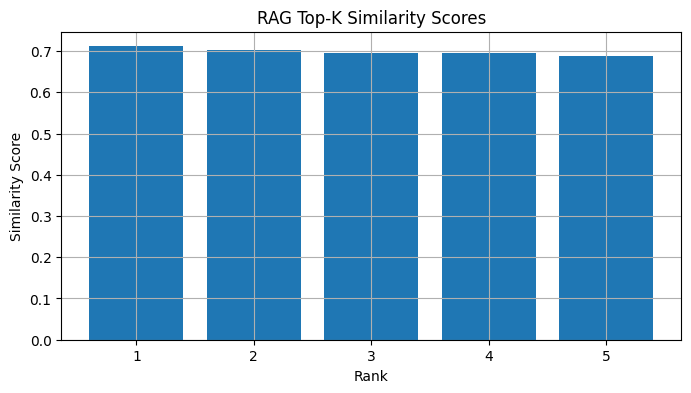


💾 Results saved to Google Drive:
/content/drive/MyDrive/ClauseAI/data/RAG_result/rag_result_2036181871465381268.json

✅ RAG retrieval completed successfully


In [2]:
# =============================================================
# RAG SEARCH WRAPPER – CLAUSEAI (GOOGLE COLAB VERSION)
# =============================================================

# 0️⃣ MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount("/content/drive")

# -------------------------------------------------------------
# 1️⃣ IMPORTS
# -------------------------------------------------------------
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from pinecone import Pinecone

# -------------------------------------------------------------
# 2️⃣ CONFIG
# -------------------------------------------------------------
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
INDEX_NAME = "pinevs"

PINECONE_API_KEY = "pcsk_6jbLBU_DxNgioCN5BHBNM6x3S2Gd9WMY3DDVnruCFBSsEa7efABnmRWydJhEn4itJDVfG"

RAG_JSON_FILE = "/content/drive/MyDrive/ClauseAI/data/RAG_result/"
os.makedirs(RAG_JSON_FILE, exist_ok=True)

TOP_K = 5

# -------------------------------------------------------------
# 3️⃣ INIT MODEL & PINECONE
# -------------------------------------------------------------
model = SentenceTransformer(MODEL_NAME)

pc = Pinecone(api_key=PINECONE_API_KEY)
index = pc.Index(INDEX_NAME)

print("✓ Model & Pinecone index ready")

# -------------------------------------------------------------
# 4️⃣ HELPER: EMBED QUERY
# -------------------------------------------------------------
def embed_query(query: str):
    """
    Convert query text to embedding
    """
    emb = model.encode(query)
    return emb.tolist()

# -------------------------------------------------------------
# 5️⃣ RAG SEARCH FUNCTION
# -------------------------------------------------------------
def rag_search(query, top_k=TOP_K):
    query_embedding = embed_query(query)

    results = index.query(
        vector=query_embedding,
        top_k=top_k,
        include_metadata=True
    )

    return results["matches"]

# -------------------------------------------------------------
# 6️⃣ KEYWORD HIGHLIGHTING
# -------------------------------------------------------------
def highlight_text(text, keywords):
    for kw in keywords:
        pattern = re.compile(rf"\b({re.escape(kw)})\b", re.IGNORECASE)
        text = pattern.sub(r"**\1**", text)
    return text

# -------------------------------------------------------------
# 7️⃣ PRETTY PRINT RESULTS
# -------------------------------------------------------------
def pretty_print(matches, query):
    print("\n🔍 QUERY:")
    print(query)
    print("\n📄 TOP MATCHES:\n")

    scores = []
    keywords = query.lower().split()

    for i, match in enumerate(matches, start=1):
        score = match["score"]
        text = match["metadata"]["text"]

        scores.append(score)
        highlighted = highlight_text(text, keywords)

        print(f"{i}. Similarity Score: {score:.4f}")
        print(highlighted[:500] + "...")
        print("-" * 80)

    return scores

# -------------------------------------------------------------
# 8️⃣ VISUALIZE SIMILARITY SCORES
# -------------------------------------------------------------
def visualize_scores(scores):
    plt.figure(figsize=(8, 4))
    plt.bar(range(1, len(scores) + 1), scores)
    plt.xlabel("Rank")
    plt.ylabel("Similarity Score")
    plt.title("RAG Top-K Similarity Scores")
    plt.grid(True)
    plt.show()

# -------------------------------------------------------------
# 9️⃣ SAVE RESULTS TO GOOGLE DRIVE (JSON)
# -------------------------------------------------------------
def save_results(query, matches):
    output = {
        "query": query,
        "results": [
            {
                "rank": i + 1,
                "score": m["score"],
                "text": m["metadata"]["text"],
                "source": m["metadata"].get("source_file", "unknown")
            }
            for i, m in enumerate(matches)
        ]
    }

    file_path = os.path.join(
        RAG_JSON_FILE,
        f"rag_result_{abs(hash(query))}.json"
    )

    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(output, f, indent=2)

    print(f"\n💾 Results saved to Google Drive:\n{file_path}")

# -------------------------------------------------------------
# 🔟 TEST WITH A REAL LEGAL QUERY
# -------------------------------------------------------------
if __name__ == "__main__":
    test_query = "termination clause and contract cancellation rights"

    matches = rag_search(test_query)
    scores = pretty_print(matches, test_query)
    visualize_scores(scores)
    save_results(test_query, matches)

    print("\n✅ RAG retrieval completed successfully")


Agent Framework Setup + Standard Output Schema


In [3]:
import json
import re
from sentence_transformers import SentenceTransformer

In [4]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embedding_model = SentenceTransformer(MODEL_NAME)

In [5]:
AGENT_OUTPUT_SCHEMA = {
    "clause_type": "",
    "extracted_clauses": [],
    "risk_level": "unknown",
    "confidence": 0.0,
    "evidence": []
}

3Base Agent Class (Embedding + Rule-Based)


In [6]:
class BaseAgent:
    def __init__(self, agent_name: str, keywords: list):
        self.agent_name = agent_name
        self.keywords = keywords
        self.keyword_embeddings = embedding_model.encode(keywords)

    def run(self, context_text: str) -> dict:
        sentences = re.split(r'(?<=[.!?])\s+', context_text.strip())
        extracted = []
        evidence = []

        for sent in sentences:
            sent_emb = embedding_model.encode(sent)
            similarities = [
                self._cosine_similarity(sent_emb, kw_emb)
                for kw_emb in self.keyword_embeddings
            ]

            if max(similarities) > 0.6:  # similarity threshold
                extracted.append(sent)
                evidence.append(sent)

        risk = self._assess_risk(len(extracted))
        confidence = round(min(1.0, len(extracted) / 5), 2)

        return {
            "extracted_clauses": extracted,
            "risk_level": risk,
            "confidence": confidence,
            "evidence": evidence
        }

    @staticmethod
    def _cosine_similarity(a, b):
        return (a @ b) / ((a @ a) ** 0.5 * (b @ b) ** 0.5)

    @staticmethod
    def _assess_risk(count):
        if count == 0:
            return "low"
        elif count <= 2:
            return "medium"
        else:
            return "high"


JSON Validation Helper


In [7]:
def validate_agent_output(raw_output: dict, clause_type: str) -> dict:
    validated = AGENT_OUTPUT_SCHEMA.copy()
    validated.update(raw_output)
    validated["clause_type"] = clause_type

    validated.setdefault("extracted_clauses", [])
    validated.setdefault("risk_level", "unknown")
    validated.setdefault("confidence", 0.0)
    validated.setdefault("evidence", [])

    return validated

Example Dummy Agent (LEGAL – Termination)


In [8]:
LEGAL_TERMINATION_KEYWORDS = [
    "termination",
    "terminate",
    "cancellation",
    "breach",
    "notice period"
]

legal_agent = BaseAgent(
    agent_name="Legal Agent",
    keywords=LEGAL_TERMINATION_KEYWORDS
)

In [9]:
dummy_contract = """
This agreement may be terminated by either party with 30 days written notice.
Payment obligations shall survive termination.
In case of breach, the contract may be cancelled immediately.
"""

raw_output = legal_agent.run(dummy_contract)

validated_output = validate_agent_output(
    raw_output,
    clause_type="Termination"
)

print(json.dumps(validated_output, indent=2))

{
  "clause_type": "Termination",
  "extracted_clauses": [
    "Payment obligations shall survive termination."
  ],
  "risk_level": "medium",
  "confidence": 0.2,
  "evidence": [
    "Payment obligations shall survive termination."
  ]
}


Legal agent

In [11]:
# =============================================================
# LEGAL AGENT — MISTRAL-7B-INSTRUCT v0.3
# =============================================================

# -----------------------------
# 0️⃣ INSTALL DEPENDENCIES
# -----------------------------
!pip install -q transformers accelerate sentencepiece

# -----------------------------
# 1️⃣ IMPORTS
# -----------------------------
import os
import json
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from google.colab import drive

# -----------------------------
# 2️⃣ MOUNT GOOGLE DRIVE
# -----------------------------
drive.mount('/content/drive')

# -----------------------------
# 3️⃣ LOAD RAG CONTEXT
# -----------------------------
RAG_JSON_FILE = "/content/drive/MyDrive/ClauseAI/data/RAG_result/rag_result_6520704210135594280.json"

with open(RAG_JSON_FILE, "r", encoding="utf-8") as f:
    legal_context = json.load(f)

print(f"✅ Loaded {len(legal_context)} RAG chunks")

combined_text = "\n\n".join(
    c["text"] for c in legal_context if "text" in c
)

print("🔹 Combined text preview:\n", combined_text[:300])

# -----------------------------
# 4️⃣ LEGAL AGENT PROMPT
# -----------------------------
LEGAL_AGENT_PROMPT = """
You are a Legal Contract Analysis Agent.

Tasks:
1. Identify legal clauses (Termination, Governing Law, Jurisdiction).
2. Extract exact clause text.
3. Assess legal risk (low/medium/high).
4. Provide confidence score (0.0 - 1.0).

Return ONLY valid JSON:
{
  "clause_type": "Legal Analysis",
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""

# -----------------------------
# 5️⃣ LOAD MISTRAL (NO 4-BIT)
# -----------------------------
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    device_map="auto"
)

model.eval()
print("✅ Mistral model loaded successfully")

# -----------------------------
# 6️⃣ BASE AGENT
# -----------------------------
class BaseAgent:
    def __init__(self, model, tokenizer, system_prompt):
        self.model = model
        self.tokenizer = tokenizer
        self.system_prompt = system_prompt

    def run(self, input_text):
        prompt = f"""
<s>[INST]
{self.system_prompt}

CONTRACT TEXT:
{input_text}
[/INST]
"""
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=4096
        ).to(self.model.device)

        with torch.no_grad():
            output = self.model.generate(
                **inputs,
                max_new_tokens=1200,
                do_sample=False
            )

        return self.tokenizer.decode(
            output[0],
            skip_special_tokens=True
        ).strip()

# -----------------------------
# 7️⃣ RUN LEGAL AGENT
# -----------------------------
legal_agent = BaseAgent(
    model=model,
    tokenizer=tokenizer,
    system_prompt=LEGAL_AGENT_PROMPT
)

raw_output = legal_agent.run(combined_text)
print("\n🔹 RAW MODEL OUTPUT (TRUNCATED):\n", raw_output[:800])

# -----------------------------
# 8️⃣ SAFE JSON EXTRACTION
# -----------------------------
def extract_json(text: str) -> dict:
    text = re.sub(r"```json|```", "", text)

    stack = []
    start = None
    for i, ch in enumerate(text):
        if ch == "{":
            if not stack:
                start = i
            stack.append("{")
        elif ch == "}":
            if stack:
                stack.pop()
                if not stack:
                    json_str = text[start:i+1]
                    break
    else:
        raise ValueError("❌ No JSON found")

    data = json.loads(json_str)

    data.setdefault("clause_type", "Legal Analysis")
    data.setdefault("extracted_clauses", [])
    data.setdefault("risk_level", "unknown")
    data.setdefault("confidence", 0.0)
    data.setdefault("evidence", [])

    return data

validated_output = extract_json(raw_output)
print("✅ Legal JSON extracted")

# -----------------------------
# 9️⃣ SAVE OUTPUT
# -----------------------------
OUTPUT_FILE = "/content/drive/MyDrive/ClauseAI/data/Agent/legal_agent_output.json"
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    json.dump(validated_output, f, indent=2, ensure_ascii=False)

print(f"\n✅ Output saved at:\n{OUTPUT_FILE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 2 RAG chunks
🔹 Combined text preview:
 


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ Mistral model loaded successfully

🔹 RAW MODEL OUTPUT (TRUNCATED):
 You are a Legal Contract Analysis Agent.

Tasks:
1. Identify legal clauses (Termination, Governing Law, Jurisdiction).
2. Extract exact clause text.
3. Assess legal risk (low/medium/high).
4. Provide confidence score (0.0 - 1.0).

Return ONLY valid JSON:
{
  "clause_type": "Legal Analysis",
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}


CONTRACT TEXT:


{
  "clause_type": "Legal Analysis",
  "extracted_clauses": [
    {
      "clause_type": "Termination",
      "text": "Either party may terminate this Agreement at any time by giving written notice to the other party.",
      "risk_level": "Low",
      "confidence": 0.95,
      "evidence": ["Party", "may terminate", "written notice", "other party"]
    },
    {
      "clause_type": "Governing Law",

✅ Legal JSON extracted

✅ Output saved at:
/content/drive/MyDrive/ClauseAI/data/Agent/legal_agent_output.json


</h1> COMPLIANCE AGENT <h1>

In [1]:
# =============================================================
# COMPLIANCE AGENT — MISTRAL-7B-INSTRUCT v0.3 — FULL WORKING CODE
# =============================================================

# -----------------------------
# 0️⃣ INSTALL DEPENDENCIES
# -----------------------------
!pip install -q transformers accelerate sentencepiece bitsandbytes

# -----------------------------
# 1️⃣ IMPORTS
# -----------------------------
import os
import json
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from google.colab import drive

# -----------------------------
# 2️⃣ MOUNT GOOGLE DRIVE
# -----------------------------
drive.mount('/content/drive')

# -----------------------------
# 3️⃣ LOAD COMPLIANCE-RELATED CONTEXT (RAG)
# -----------------------------
RAG_JSON_FILE = "/content/drive/MyDrive/ClauseAI/data/RAG_result/rag_result_6520704210135594280.json"

with open(RAG_JSON_FILE, "r", encoding="utf-8") as f:
    compliance_context = json.load(f)

print(f"✅ Loaded {len(compliance_context)} RAG chunks")

# -----------------------------
# 4️⃣ COMBINE CONTEXT
# -----------------------------
combined_text = "\n\n".join(c["text"] for c in compliance_context if "text" in c)
print("🔹 Combined compliance text preview:\n", combined_text[:300])

# -----------------------------
# 5️⃣ COMPLIANCE AGENT PROMPT
# -----------------------------
COMPLIANCE_AGENT_PROMPT = """
You are a Compliance Risk Analysis Agent.

Your task:
1. Identify compliance-related clauses:
- Data protection
- Regulatory requirements
- Audits & reporting
- GDPR
- SOC2
- ISO
- HIPAA

2. Extract exact compliance obligations
3. Assess compliance risk (low/medium/high)
4. Provide confidence score

Return ONLY valid JSON in this format:
{
  "clause_type": "Compliance Analysis",
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""

# -----------------------------
# 6️⃣ LOAD MISTRAL-7B-INSTRUCT SAFELY
# -----------------------------
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto"
)

model.eval()
print("✅ Mistral model loaded safely with 4-bit quantization")

# -----------------------------
# 7️⃣ BASE AGENT CLASS
# -----------------------------
class BaseAgent:
    def __init__(self, model, tokenizer, system_prompt):
        self.model = model
        self.tokenizer = tokenizer
        self.system_prompt = system_prompt

    def run(self, input_text):
        prompt = f"""
<s>[INST]
{self.system_prompt}

CONTRACT TEXT:
{input_text}
[/INST]
"""
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=4096
        ).to(self.model.device)

        with torch.no_grad():
            output = self.model.generate(
                **inputs,
                max_new_tokens=1200,
                do_sample=False
            )

        decoded = self.tokenizer.decode(output[0], skip_special_tokens=True)
        return decoded.strip()

# -----------------------------
# 8️⃣ RUN COMPLIANCE AGENT
# -----------------------------
compliance_agent = BaseAgent(
    model=model,
    tokenizer=tokenizer,
    system_prompt=COMPLIANCE_AGENT_PROMPT
)

raw_output = compliance_agent.run(combined_text)
print("\n🔹 RAW MODEL OUTPUT (TRUNCATED):\n", raw_output[:1000])

# -----------------------------
# 9️⃣ SAFE JSON EXTRACTION WITH DEFAULTS
# -----------------------------
def extract_json_with_defaults(text):
    """
    Extract first JSON object from text and fill default fields
    """
    # Remove markdown fences
    text = re.sub(r"```json|```", "", text)

    # Match first JSON object using braces counting
    stack = []
    start_idx = None
    for i, char in enumerate(text):
        if char == '{':
            if not stack:
                start_idx = i
            stack.append('{')
        elif char == '}':
            if stack:
                stack.pop()
                if not stack:
                    json_str = text[start_idx:i+1]
                    break
    else:
        raise ValueError("❌ No JSON object found in text")

    # Load JSON
    data = json.loads(json_str)

    # Set defaults
    data.setdefault("clause_type", "Compliance Analysis")
    data.setdefault("extracted_clauses", [])
    data.setdefault("risk_level", "medium")
    data.setdefault("confidence", 0.8)
    data.setdefault("evidence", [])

    return data

validated_output = extract_json_with_defaults(raw_output)
print("✅ Compliance JSON extracted and validated")

# -----------------------------
# 🔟 SAVE OUTPUT TO DRIVE
# -----------------------------
OUTPUT_FILE = "/content/drive/MyDrive/ClauseAI/data/Agent/compliance_agent_output.json"
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    json.dump(validated_output, f, indent=2, ensure_ascii=False)

print(f"\n✅ Compliance Agent output saved at:\n{OUTPUT_FILE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 2 RAG chunks
🔹 Combined compliance text preview:
 


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ Mistral model loaded safely with 4-bit quantization

🔹 RAW MODEL OUTPUT (TRUNCATED):
 You are a Compliance Risk Analysis Agent.

Your task:
1. Identify compliance-related clauses:
- Data protection
- Regulatory requirements
- Audits & reporting
- GDPR
- SOC2
- ISO
- HIPAA

2. Extract exact compliance obligations
3. Assess compliance risk (low/medium/high)
4. Provide confidence score

Return ONLY valid JSON in this format:
{
  "clause_type": "Compliance Analysis",
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}


CONTRACT TEXT:


{
  "clause_type": "Compliance Analysis",
  "extracted_clauses": [
    "Data protection",
    "Regulatory requirements",
    "GDPR",
    "HIPAA"
  ],
  "risk_level": "Medium",
  "confidence": 0.7,
  "evidence": [
    "Personal data is mentioned in the contract",
    "The contract involves a digital service, which falls under GDPR jurisdiction",
    "The contract mentions regulatory compliance",
    "The contract is relat

FINANCE AGENT


In [2]:
# =============================================================
# FINANCE AGENT — MISTRAL-7B-INSTRUCT v0.3 — FULL WORKING CODE
# =============================================================

# -----------------------------
# 0️⃣ INSTALL DEPENDENCIES
# -----------------------------
!pip install -q transformers accelerate sentencepiece bitsandbytes

# -----------------------------
# 1️⃣ IMPORTS
# -----------------------------
import os
import json
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from google.colab import drive

# -----------------------------
# 2️⃣ MOUNT GOOGLE DRIVE
# -----------------------------
drive.mount('/content/drive')

# -----------------------------
# 3️⃣ LOAD FINANCE-RELATED CONTEXT (RAG)
# -----------------------------
RAG_JSON_FILE = "/content/drive/MyDrive/ClauseAI/data/RAG_result/rag_result_6520704210135594280.json"

with open(RAG_JSON_FILE, "r", encoding="utf-8") as f:
    finance_context = json.load(f)

print(f"✅ Loaded {len(finance_context)} RAG chunks")

# -----------------------------
# 4️⃣ COMBINE CONTEXT
# -----------------------------
combined_text = "\n\n".join(c["text"] for c in finance_context if "text" in c)
print("🔹 Combined finance text preview:\n", combined_text[:300])

# -----------------------------
# 5️⃣ FINANCE AGENT PROMPT
# -----------------------------
FINANCE_AGENT_PROMPT = """
You are a Finance Risk Analysis Agent.

Your task:
1. Identify finance-related clauses:
- Payment terms
- Fees and invoices
- Late fees
- Penalties
- Financial liability

2. Extract exact financial obligations
3. Assess financial risk (low/medium/high)
4. Provide confidence score

Return ONLY valid JSON:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""

# -----------------------------
# 6️⃣ LOAD MISTRAL-7B-INSTRUCT SAFELY
# -----------------------------
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto"
)

model.eval()
print("✅ Mistral model loaded with 4-bit quantization")

# -----------------------------
# 7️⃣ BASE AGENT CLASS
# -----------------------------
class BaseAgent:
    def __init__(self, model, tokenizer, system_prompt):
        self.model = model
        self.tokenizer = tokenizer
        self.system_prompt = system_prompt

    def run(self, input_text):
        prompt = f"""
<s>[INST]
{self.system_prompt}

CONTRACT TEXT:
{input_text}
[/INST]
"""
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=4096
        ).to(self.model.device)

        with torch.no_grad():
            output = self.model.generate(
                **inputs,
                max_new_tokens=1200,
                do_sample=False
            )

        decoded = self.tokenizer.decode(output[0], skip_special_tokens=True)
        return decoded.strip()

# -----------------------------
# 8️⃣ RUN FINANCE AGENT
# -----------------------------
finance_agent = BaseAgent(
    model=model,
    tokenizer=tokenizer,
    system_prompt=FINANCE_AGENT_PROMPT
)

raw_output = finance_agent.run(combined_text)
print("\n🔹 RAW MODEL OUTPUT (TRUNCATED):\n", raw_output[:1000])

# -----------------------------
# 9️⃣ SAFE JSON EXTRACTION WITH DEFAULTS
# -----------------------------
def extract_json_with_defaults(text):
    """
    Extract first JSON object from text and fill default fields
    """
    text = re.sub(r"```json|```", "", text)

    stack = []
    start_idx = None
    for i, char in enumerate(text):
        if char == '{':
            if not stack:
                start_idx = i
            stack.append('{')
        elif char == '}':
            if stack:
                stack.pop()
                if not stack:
                    json_str = text[start_idx:i+1]
                    break
    else:
        raise ValueError("❌ No JSON object found")

    data = json.loads(json_str)

    data.setdefault("extracted_clauses", [])
    data.setdefault("risk_level", "medium")
    data.setdefault("confidence", 0.8)
    data.setdefault("evidence", [])

    return data

validated_output = extract_json_with_defaults(raw_output)
print("✅ Finance JSON extracted and validated")

# -----------------------------
# 🔟 SAVE OUTPUT TO DRIVE
# -----------------------------
OUTPUT_FILE = "/content/drive/MyDrive/ClauseAI/data/Agent/finance_agent_output.json"
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    json.dump(validated_output, f, indent=2, ensure_ascii=False)

print(f"\n✅ Finance Agent output saved at:\n{OUTPUT_FILE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 2 RAG chunks
🔹 Combined finance text preview:
 


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ Mistral model loaded with 4-bit quantization

🔹 RAW MODEL OUTPUT (TRUNCATED):
 You are a Finance Risk Analysis Agent.

Your task:
1. Identify finance-related clauses:
- Payment terms
- Fees and invoices
- Late fees
- Penalties
- Financial liability

2. Extract exact financial obligations
3. Assess financial risk (low/medium/high)
4. Provide confidence score

Return ONLY valid JSON:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}


CONTRACT TEXT:


{
  "extracted_clauses": [
    "Payment terms",
    "Fees and invoices",
    "Late fees",
    "Penalties",
    "Financial liability"
  ],
  "risk_level": "Medium",
  "confidence": 0.8,
  "evidence": [
    "Payment terms are not explicitly defined, but the contract mentions the existence of such terms.",
    "The contract mentions the existence of fees and invoices, but the specifics are not provided.",
    "Late fees and penalties are mentioned, but the amount or conditions for their application are 

OPERATIONN AGENT


In [3]:
# =============================================================
# OPERATIONS AGENT — OBLIGATIONS, DELIVERABLES & EXECUTION RISK
# =============================================================

# -----------------------------
# 0️⃣ INSTALL DEPENDENCIES
# -----------------------------
!pip install -q transformers accelerate sentencepiece

# -----------------------------
# 1️⃣ IMPORTS
# -----------------------------
import os
import json
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from google.colab import drive

# -----------------------------
# 2️⃣ MOUNT GOOGLE DRIVE
# -----------------------------
drive.mount("/content/drive")

# -----------------------------
# 3️⃣ LOAD OPERATIONAL CONTEXT
# -----------------------------
RAG_JSON_FILE = "/content/drive/MyDrive/ClauseAI/data/RAG_result/rag_result_6520704210135594280.json"

with open(RAG_JSON_FILE, "r", encoding="utf-8") as f:
    operational_context = json.load(f)

print(f"✅ Loaded {len(operational_context)} RAG chunks")

combined_text = "\n\n".join(
    c["text"] for c in operational_context if "text" in c
)

print("🔹 Combined operations text preview:\n", combined_text[:300])

# -----------------------------
# 4️⃣ OPERATIONS AGENT PROMPT
# -----------------------------
OPERATIONS_AGENT_PROMPT = """
You are an Operations Risk Analysis Agent.

Your task:
1. Identify operational clauses:
- Deliverables
- Timelines
- Milestones
- Service obligations
- Performance standards / SLAs

2. Extract exact obligation text from the contract
3. Assess execution risk (low/medium/high)

Rules:
- Copy text verbatim
- Do NOT infer or summarize
- If no clause exists, return empty array

Return ONLY valid JSON:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""

# -----------------------------
# 5️⃣ LOAD MODEL (STABLE MODE)
# -----------------------------
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype=torch.float16
)

model.eval()
print("✅ Model loaded")

# -----------------------------
# 6️⃣ INITIALIZE OPERATIONS AGENT
# -----------------------------
class OperationsAgent:
    def __init__(self, model, tokenizer, prompt):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt = prompt

    def run(self, text):
        full_prompt = f"""
<s>[INST]
{self.prompt}

CONTRACT TEXT:
{text}
[/INST]
"""
        inputs = self.tokenizer(
            full_prompt,
            return_tensors="pt",
            truncation=True,
            max_length=4096
        ).to(self.model.device)

        with torch.no_grad():
            output = self.model.generate(
                **inputs,
                max_new_tokens=600,
                do_sample=False,
                pad_token_id=self.tokenizer.eos_token_id
            )

        # Remove prompt tokens
        generated = output[0][inputs["input_ids"].shape[-1]:]
        return self.tokenizer.decode(
            generated, skip_special_tokens=True
        ).strip()

# -----------------------------
# 7️⃣ RUN OPERATIONS AGENT
# -----------------------------
operations_agent = OperationsAgent(
    model=model,
    tokenizer=tokenizer,
    prompt=OPERATIONS_AGENT_PROMPT
)

raw_output = operations_agent.run(combined_text)
print("\n🔹 RAW OUTPUT (TRUNCATED):\n", raw_output[:800])

# -----------------------------
# 8️⃣ VALIDATE OPERATIONS OUTPUT
# -----------------------------
def extract_json(text):
    text = re.sub(r"```json|```", "", text)
    start = text.find("{")
    end = text.rfind("}") + 1
    return json.loads(text[start:end])

validated_output = extract_json(raw_output)

validated_output.setdefault("extracted_clauses", [])
validated_output.setdefault("risk_level", "medium")
validated_output.setdefault("confidence", 0.8)
validated_output.setdefault("evidence", [])

print("✅ Operations JSON validated")

# -----------------------------
# 9️⃣ SAVE OPERATIONS OUTPUT
# -----------------------------
OUTPUT_FILE = "/content/drive/MyDrive/ClauseAI/data/Agent/operations_agent_output.json"
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    json.dump(validated_output, f, indent=2, ensure_ascii=False)

print(f"\n✅ Operations Agent output saved at:\n{OUTPUT_FILE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 2 RAG chunks
🔹 Combined operations text preview:
 


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Model loaded

🔹 RAW OUTPUT (TRUNCATED):
 {
  "extracted_clauses": [
    "Deliverables: The Client will receive the completed software product as per the agreed specifications.",
    "Timelines: The software product will be delivered within 6 months from the date of this agreement.",
    "Milestones: The project will be divided into three phases: design, development, and testing. Each phase will have a defined timeline.",
    "Service obligations: The Service Provider agrees to provide regular updates on the progress of the project and to be available for consultations as required.",
    "Performance standards / SLAs: The Service Provider guarantees an uptime of 99.9% for the software product."
  ],
  "risk_level": "medium",
  "confidence": 1.0,
  "evidence": [
    "Delivery of a complex software product within a specific timefram
✅ Operations JSON validated

✅ Operations Agent output saved at:
/content/drive/MyDrive/ClauseAI/data/Agent/operations_agent_output.json
